# Initial Setup

In [1]:
%%capture
%load_ext autoreload
%autoreload 2

from tqdm.notebook import trange, tqdm
from random import random
import pandas as pd
import matplotlib
import numpy as np
import csv
import itertools
import pickle as pkl

import time
import datetime
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal
import mplfinance as mpl

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

from IPython.display import Audio
sound_file = '../sound/done.mp3'
Audio(sound_file, autoplay=True)

import pmdarima as pm
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error as mse

import prophet

from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *
from Pmdarima_Model import Pmdarima_Model


# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key

## Get NYSE calendar

In [2]:
NYSE = mcal.get_calendar('NYSE')

## Set up Frequency Variables

### Custom Business Hour

In [3]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<CustomBusinessHour: CBH=05:00-21:00>

### Custom Business Day

In [4]:
# CBD = pd.offsets.CustomBusinessDay(calendar=CustomUSHolidayCalendar())
CBD = NYSE.holidays()
CBD

<CustomBusinessDay>

# YFinance

## Setup / Gather Data

In [5]:
ticker = 'SPY'
YF_COLUMNS = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

In [6]:
years = [3, 5, 10, 30]
get_yf_time_series(yf, years, ticker, freq=CBD)

## Load Data from File

### 3Y

In [7]:
spy_df_3Y = load_yf_time_series(yf, 3, ticker, freq=CBD)

### 5Y

In [8]:
spy_df_5Y = load_yf_time_series(yf, 5, ticker, freq=CBD)

### 10Y

In [9]:
spy_df_10Y = load_yf_time_series(yf, 10, ticker, freq=CBD)

### All (28Y)

In [147]:
spy_df_all = load_yf_time_series(yf, 30, ticker, freq=CBD)

## Data Preparation

### EDA

In [148]:
spy_df_all

,open,high,low,close,adj_close,volume
date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.884184,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,26.068277,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,26.123499,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,26.399649,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,26.510111,531500
...,...,...,...,...,...,...
2021-05-03,419.429993,419.839996,417.670013,418.200012,418.200012,68128300
2021-05-04,416.070007,416.600006,411.670013,415.619995,415.619995,101591200
2021-05-05,417.380005,417.630005,415.149994,415.750000,415.750000,39960700


In [149]:
spy_df_3Y = spy_df_3Y.asfreq(CBD)
spy_df_5Y = spy_df_5Y.asfreq(CBD)
spy_df_10Y = spy_df_10Y.asfreq(CBD)
spy_df_all = spy_df_all.asfreq(CBD)

In [13]:
spy_df_10Y.isna().sum(), spy_df_10Y.isna().sum(), spy_df_10Y.isna().sum()

(open         0
 high         0
 low          0
 close        0
 adj_close    0
 volume       0
 dtype: int64,
 open         0
 high         0
 low          0
 close        0
 adj_close    0
 volume       0
 dtype: int64,
 open         0
 high         0
 low          0
 close        0
 adj_close    0
 volume       0
 dtype: int64)

### Remove today's incomplete data (if needed)

In [14]:
# spy_df_3Y.drop(spy_df_3Y.tail(1).index, inplace=True)
# spy_df_5Y.drop(spy_df_5Y.tail(1).index, inplace=True)
# spy_df_10Y.drop(spy_df_10Y.tail(1).index, inplace=True)

### Impute Missing Values

In [15]:
# spy_df_3Y = spy_df_3Y.interpolate()
# spy_df_5Y = spy_df_5Y.interpolate()
# spy_df_10Y = spy_df_10Y.interpolate()

### Create Time Series for `Close`, `Volume`

In [150]:
df_3Y_close = spy_df_3Y.close
df_3Y_vol = spy_df_3Y.volume
df_5Y_close = spy_df_5Y.close
df_5Y_vol = spy_df_5Y.volume
df_10Y_close = spy_df_10Y.close
df_10Y_vol = spy_df_10Y.volume
df_all_close = spy_df_all.close
df_all_vol = spy_df_all.volume

In [151]:
df_all_close

date
1993-01-29     43.937500
1993-02-01     44.250000
1993-02-02     44.343750
1993-02-03     44.812500
1993-02-04     45.000000
                 ...    
2021-05-03    418.200012
2021-05-04    415.619995
2021-05-05    415.750000
2021-05-06    419.070007
2021-05-07    422.119995
Freq: C, Name: close, Length: 7120, dtype: float64

In [152]:
df_all_close.isna().sum()

0

In [17]:
df_10Y_close, df_10Y_vol

(date
 2011-05-02    136.220001
 2011-05-03    135.729996
 2011-05-04    134.830002
 2011-05-05    133.610001
 2011-05-06    134.199997
                  ...    
 2021-04-30    417.299988
 2021-05-03    418.200012
 2021-05-04    415.619995
 2021-05-05    415.750000
 2021-05-06    419.070007
 Name: close, Length: 2521, dtype: float64,
 date
 2011-05-02    126278700
 2011-05-03    138375000
 2011-05-04    182678500
 2011-05-05    226900000
 2011-05-06    222787200
                 ...    
 2021-04-30     85448400
 2021-05-03     68128300
 2021-05-04    101591200
 2021-05-05     39960700
 2021-05-06     73813600
 Name: volume, Length: 2521, dtype: int64)

### Create Time Series for `Open`, `High`, `Low`, `adj_close`

In [153]:
df_3Y_open = spy_df_3Y.open
df_3Y_high = spy_df_3Y.high
df_3Y_low = spy_df_3Y.open
df_3Y_a_close = spy_df_3Y.adj_close
df_5Y_open = spy_df_5Y.open
df_5Y_high = spy_df_5Y.high
df_5Y_low = spy_df_5Y.open
df_5Y_a_close = spy_df_5Y.adj_close
df_10Y_open = spy_df_10Y.open
df_10Y_high = spy_df_10Y.high
df_10Y_low = spy_df_10Y.open
df_10Y_a_close = spy_df_10Y.adj_close
df_all_open = spy_df_all.open
df_all_high = spy_df_all.high
df_all_low = spy_df_all.open
df_all_a_close = spy_df_all.adj_close

### Create 2D Volume Time Series

In [23]:
df_3Y_close.shape

(788,)

In [24]:
vol_3Y_df = pd.DataFrame(df_3Y_vol).reset_index()
vol_5Y_df = pd.DataFrame(df_5Y_vol).reset_index()
vol_10Y_df = pd.DataFrame(df_10Y_vol).reset_index()

### Create Future Dates

In [25]:
# no longer needed due to custom function

today = pd.Timestamp.today()
new_dates = pd.date_range(start=today, periods=5, freq=CBD)

index_3Y_fc = range(df_3Y_close.size, df_3Y_close.size + 5)
index_5Y_fc = range(df_5Y_close.size, df_5Y_close.size + 5)
index_10Y_fc = range(df_10Y_close.size, df_10Y_close.size + 5)

new_dates_3Y_df = pd.DataFrame(new_dates, index=index_3Y_fc, columns=['date'])
new_dates_5Y_df = pd.DataFrame(new_dates, index=index_5Y_fc, columns=['date'])
new_dates_10Y_df = pd.DataFrame(new_dates, index=index_10Y_fc, columns=['date'])

## Plot PACF

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



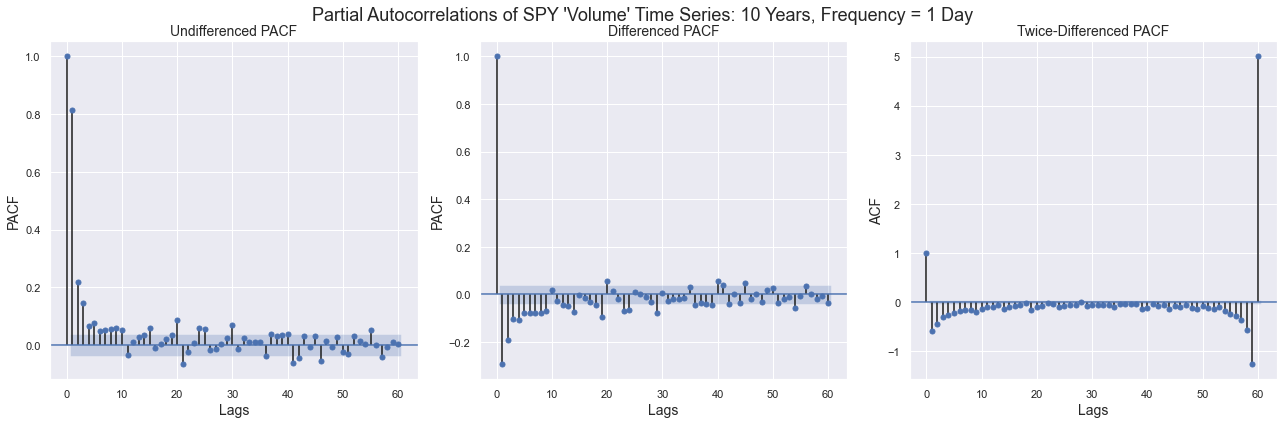

In [255]:
plot_pacf_with_diff(df_10Y_vol, 'SPY \'Volume\'', 10, 'years', '1 Day', lags=60)

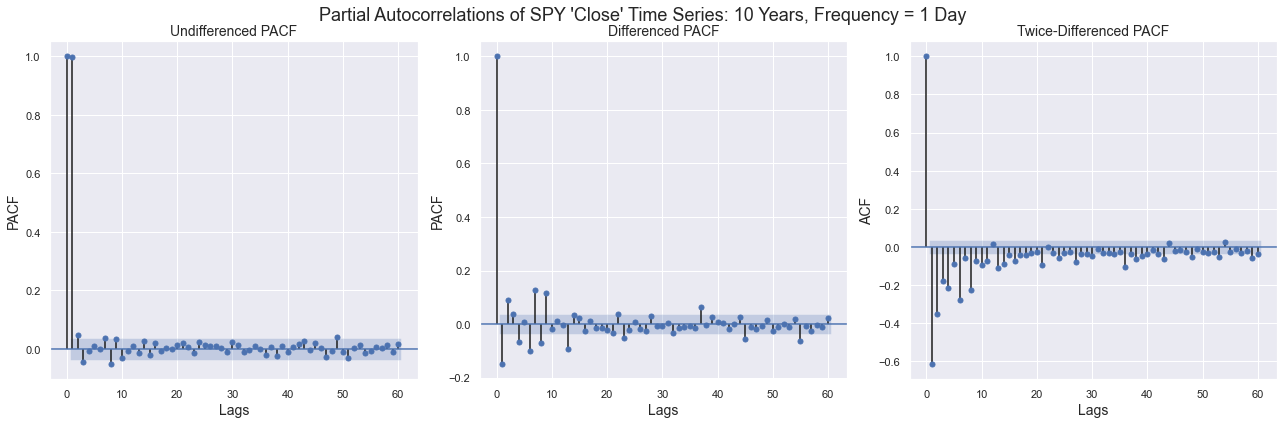

In [257]:
plot_pacf_with_diff(df_10Y_close, 'SPY \'Close\'', 10, 'years', '1 Day', lags=60)

## Plot ACF

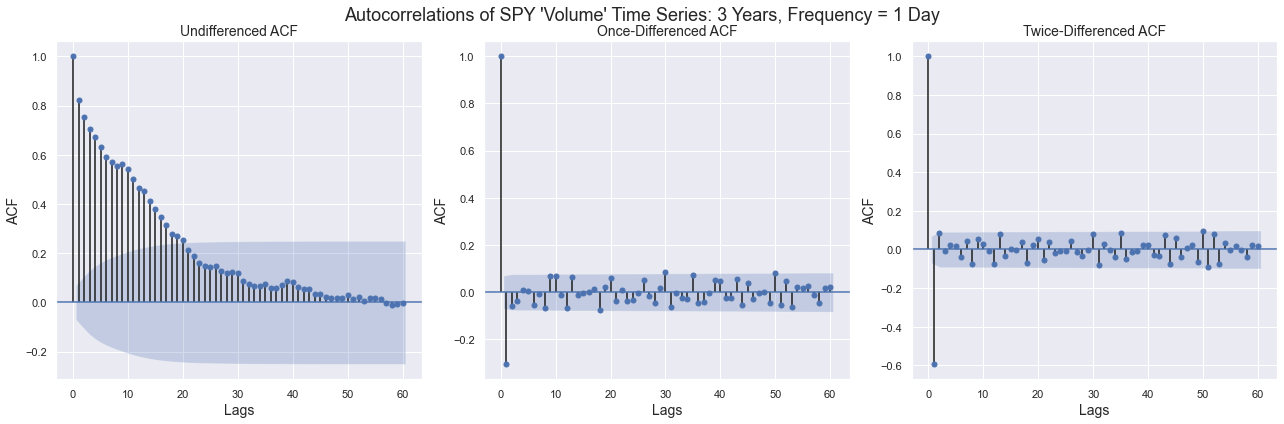

In [28]:
plot_acf_with_diff(df_3Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

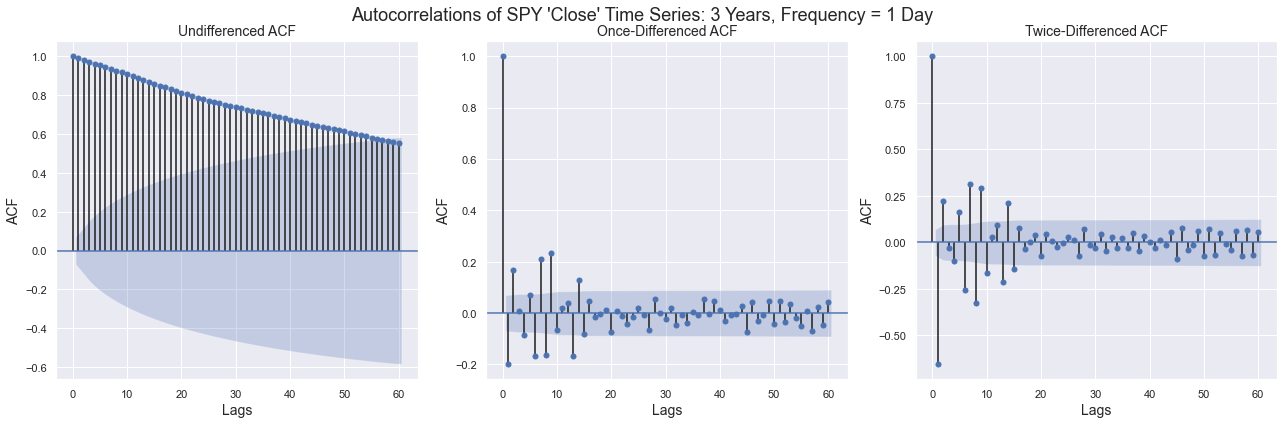

In [29]:
plot_acf_with_diff(df_3Y_close, 'SPY \'Close\'', 3, 'years', '1 Day', lags=300)

## Plot Seasonal Decomposition

### 3 Years, Freq = Custom Business Day, Yearly Seasonality

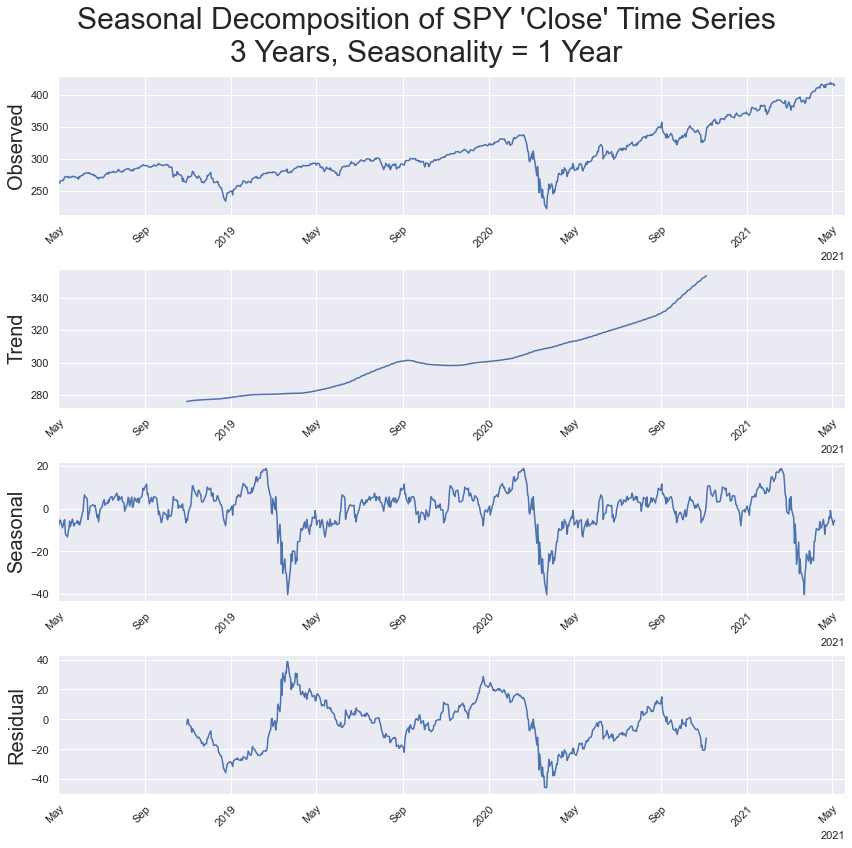

In [30]:
plot_seasonal_decomposition(df_3Y_close, 'SPY \'Close\'', 3, 'years', '1 Day', 261)

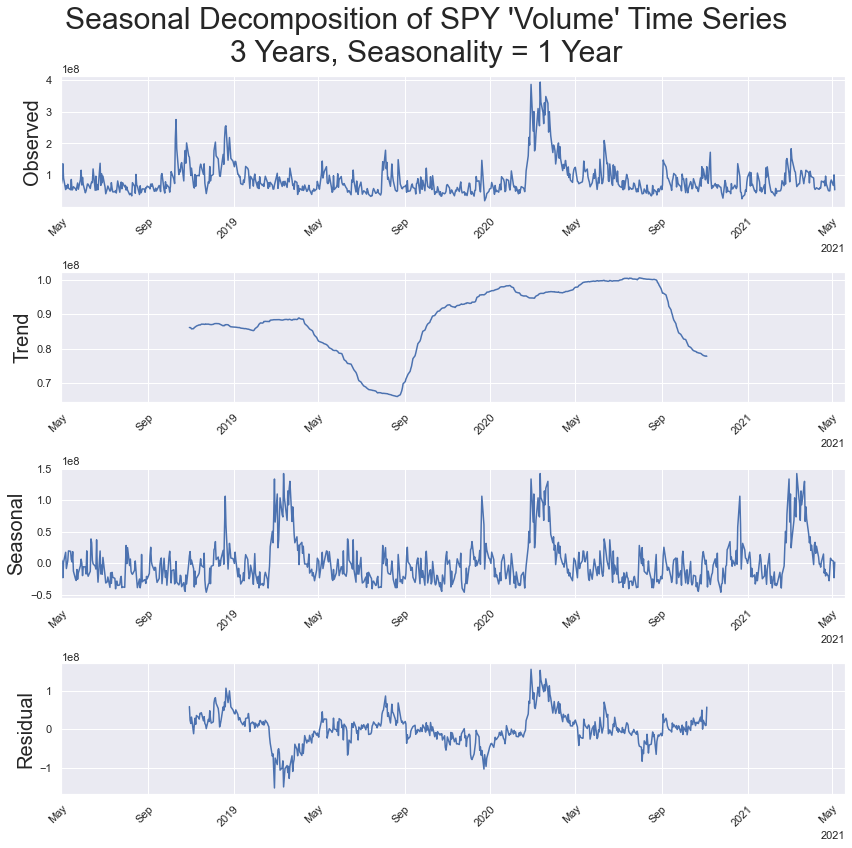

In [266]:
plot_seasonal_decomposition(df_3Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', 261)

### 5 Years, Freq = Custom Business Day, Yearly Seasonality

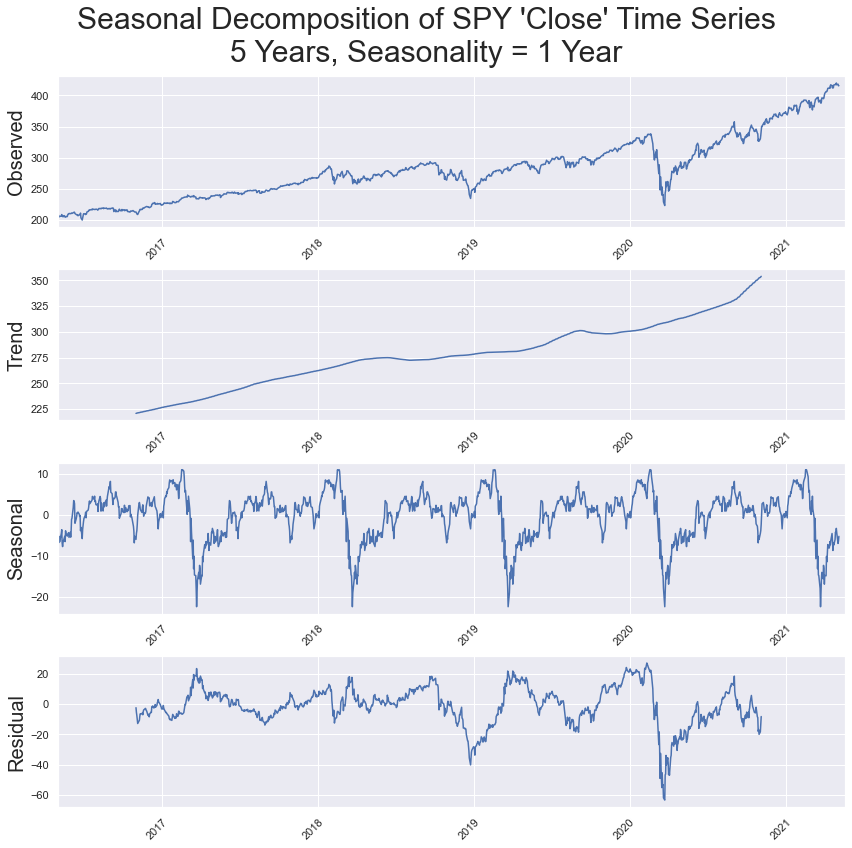

In [32]:
plot_seasonal_decomposition(df_5Y_close, 'SPY \'Close\'', 5, 'years', '1 Day', 261)

### 10 Years, Freq = Custom Business Day, Yearly Seasonality

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


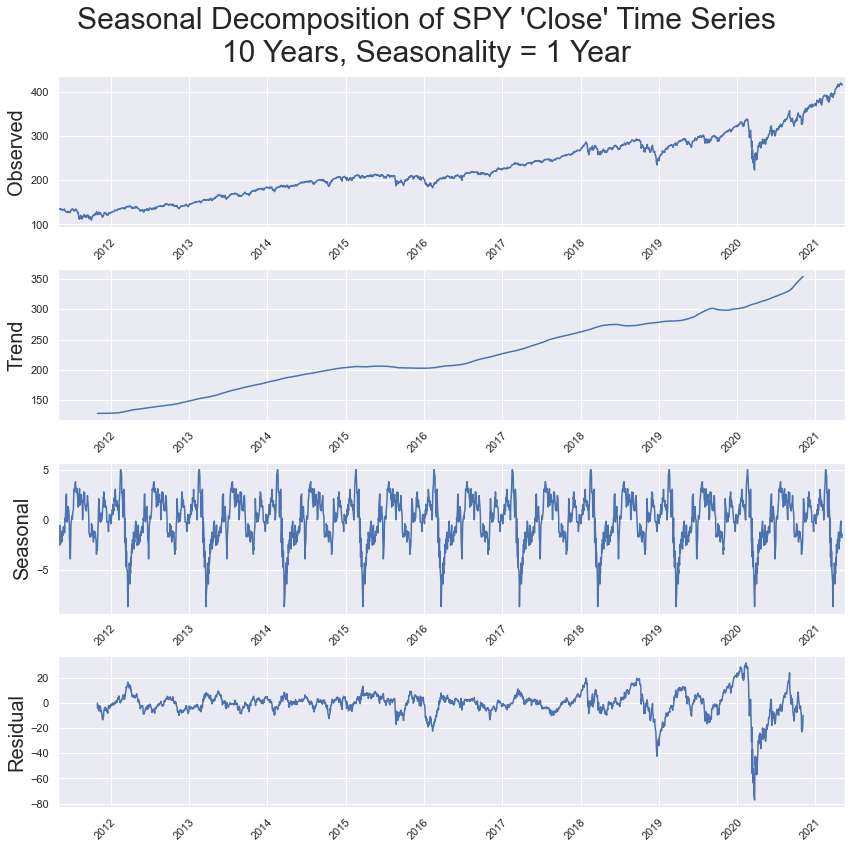

In [259]:
plot_seasonal_decomposition(df_10Y_close, 'SPY \'Close\'', 10, 'years', '1 Day', 261)

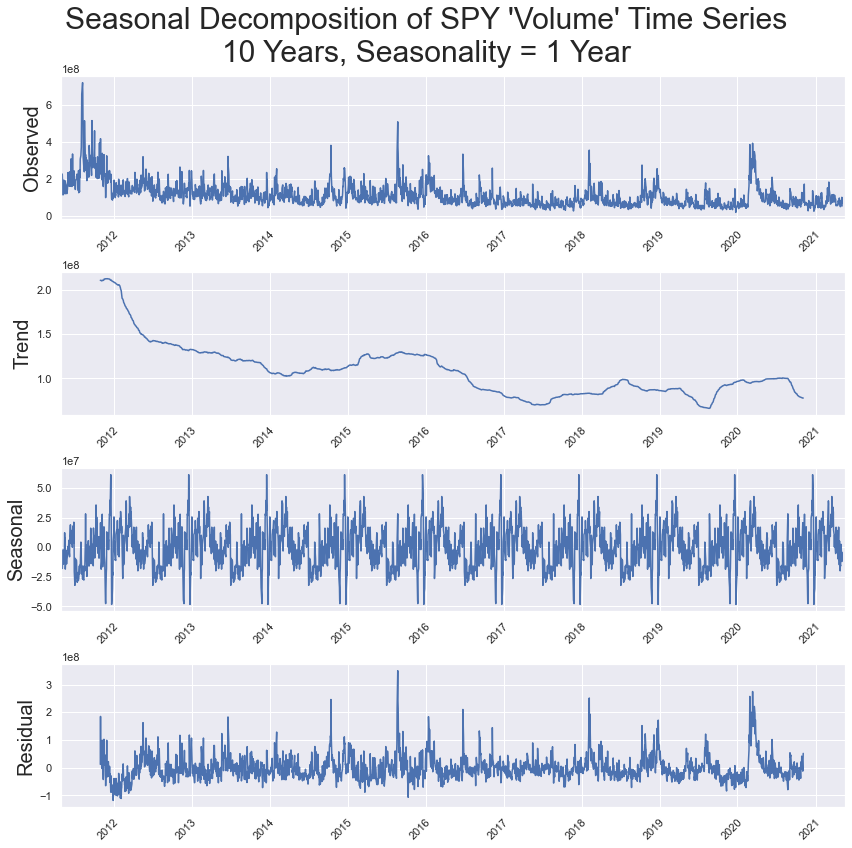

In [265]:
plot_seasonal_decomposition(df_10Y_vol, 'SPY \'Volume\'', 10, 'years', '1 Day', 261)

# Modeling with Close, Volume

## Last 3 Years, 1 Day

### Using Custom Class `Pmdarima_Model`

In [260]:
df_3Y_close.min()

222.9499969482422

#### Close

In [17]:
pam_3Y_close = Pmdarima_Model(df_3Y_close, 'SPY \'Close\'', order=(0,0,0),
               n=3, periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, trend='t', k=4,
               date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Data set diffs to use: 1
Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3440.897, Time=1.81 sec
First viable model found (3440.897)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3486.669, Time=1.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3451.308, Time=2.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3460.270, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3484.923, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3440.157, Time=1.43 sec
New best model found (3440.157 < 3440.897)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3439.208, Time=0.77 sec
New best model found (3439.208 < 3440.157)
 AR

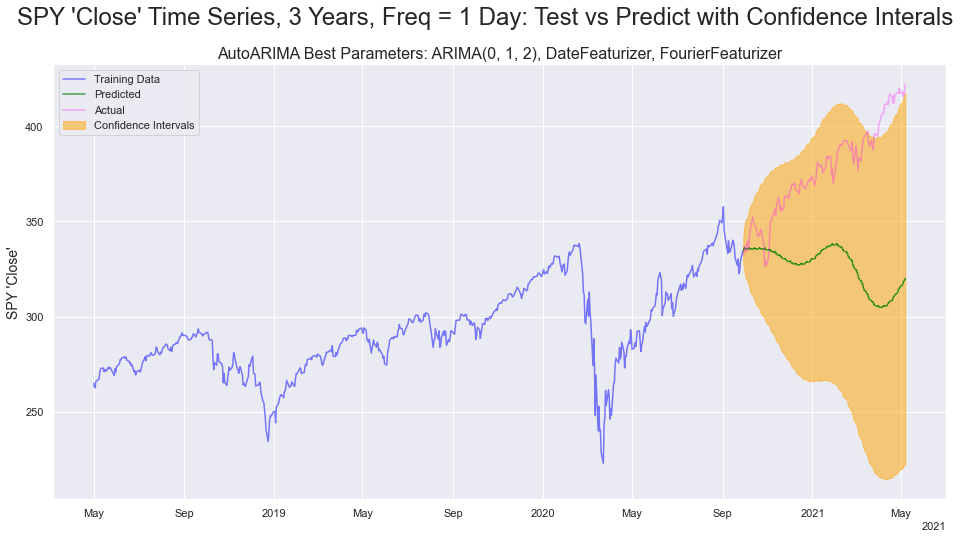

In [18]:
pam_3Y_auto_pipe = pam_3Y_close.run_auto_pipeline(verbose=1, visualize=True)

In [19]:
pam_3Y_close.AA_best_mod_params_df

,ARIMA_Order,Trend,Intercept,Date,Fourier,Fourier_m,Fourier_k,BoxCox,Log,Scored,AIC,RMSE,RMSE%,SMAPE
Model,,,,,,,,,,,,,,
0,"(0, 1, 2)",c,False,True,True,252,4,False,False,False,None,None,None,None


ARIMA(0, 1, 2), DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
Test AIC: 4264.826
Test RMSE: 3.607
This is 1.233% of the avg observed value.
Test SMAPE: 0.743%

Adding a new score.
Model not found.


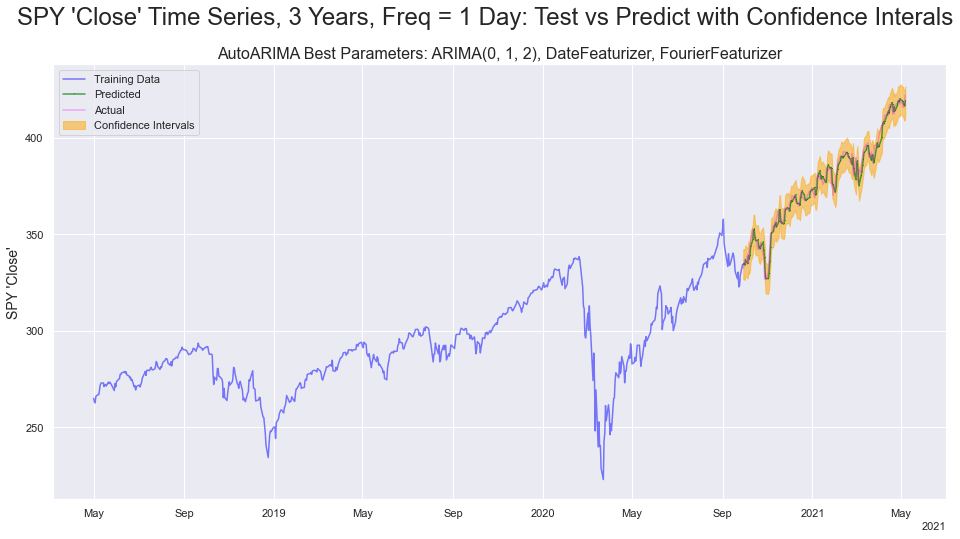

In [20]:
AIC, RMSE, RMSE_pc, SMAPE = pam_3Y_close.run_stepwise_CV(func='AA', dynamic=False, verbose=1, visualize=True)

In [123]:
Audio(sound_file, autoplay=True)

Pmdarima_Model.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data..


Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
Running normally.


________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4265.037 | RMSE: 3.676 | RMSE%=1.257% | SMAPE 0.770%
Model[ARIMA Order(1, 0, 6)['t'], Intercept, DateFeaturizer]: AIC=4265.037 | RMSE=3.676 | RMSE_pc=1.257% | SMAPE=0.770%
Adding a new score to file... Model found in file. Not yet scored.   Index is 625
Adding scores to model, updating line 625. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4264.094 | RMSE: 3.707 | RMSE%=1.267% | SMAPE 0.779%
Model[ARIMA Order(1, 0, 6)['ct'], Intercept, DateFeaturizer]: AIC=4264.094 | RMSE=3.707 | RMSE_pc=1.267% | SMAPE=0.779%
Adding a new score to file... Model found in file. Not yet scored.   Index is 626
Adding scores to model, updating line 626. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4242.586 | RMSE: 3.679 | RMSE%=1.257% | SMAPE 0.769%
Model[ARIMA Order(2, 0, 5)['t'], Intercept, DateFeaturizer]: AIC=4242.586 | RMSE=3.679 | RMSE_pc=1.257% | SMAPE=0.769%
Adding a new score to file... Model found in file. Not yet scored.   Index is 627
Adding scores to model, updating line 627. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4241.888 | RMSE: 3.709 | RMSE%=1.268% | SMAPE 0.779%
Model[ARIMA Order(2, 0, 5)['ct'], Intercept, DateFeaturizer]: AIC=4241.888 | RMSE=3.709 | RMSE_pc=1.268% | SMAPE=0.779%
Adding a new score to file... Model found in file. Not yet scored.   Index is 628
Adding scores to model, updating line 628. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4234.914 | RMSE: 3.629 | RMSE%=1.241% | SMAPE 0.760%
Model[ARIMA Order(2, 0, 6)['t'], Intercept, DateFeaturizer]: AIC=4234.914 | RMSE=3.629 | RMSE_pc=1.241% | SMAPE=0.760%
Adding a new score to file... Model found in file. Not yet scored.   Index is 629
Adding scores to model, updating line 629. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4232.903 | RMSE: 3.616 | RMSE%=1.236% | SMAPE 0.758%
Model[ARIMA Order(2, 0, 6)['ct'], Intercept, DateFeaturizer]: AIC=4232.903 | RMSE=3.616 | RMSE_pc=1.236% | SMAPE=0.758%
Adding a new score to file... Model found in file. Not yet scored.   Index is 630
Adding scores to model, updating line 630. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4221.724 | RMSE: 3.560 | RMSE%=1.217% | SMAPE 0.752%
Model[ARIMA Order(3, 0, 4)['t'], Intercept, DateFeaturizer]: AIC=4221.724 | RMSE=3.560 | RMSE_pc=1.217% | SMAPE=0.752%
Adding a new score to file... Model found in file. Not yet scored.   Index is 631
Adding scores to model, updating line 631. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4220.684 | RMSE: 3.570 | RMSE%=1.220% | SMAPE 0.754%
Model[ARIMA Order(3, 0, 4)['ct'], Intercept, DateFeaturizer]: AIC=4220.684 | RMSE=3.570 | RMSE_pc=1.220% | SMAPE=0.754%
Adding a new score to file... Model found in file. Not yet scored.   Index is 632
Adding scores to model, updating line 632. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4244.298 | RMSE: 3.679 | RMSE%=1.257% | SMAPE 0.770%
Model[ARIMA Order(3, 0, 5)['t'], Intercept, DateFeaturizer]: AIC=4244.298 | RMSE=3.679 | RMSE_pc=1.257% | SMAPE=0.770%
Adding a new score to file... Model found in file. Not yet scored.   Index is 633
Adding scores to model, updating line 633. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4243.542 | RMSE: 3.698 | RMSE%=1.264% | SMAPE 0.776%
Model[ARIMA Order(3, 0, 5)['ct'], Intercept, DateFeaturizer]: AIC=4243.542 | RMSE=3.698 | RMSE_pc=1.264% | SMAPE=0.776%
Adding a new score to file... Model found in file. Not yet scored.   Index is 634
Adding scores to model, updating line 634. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4217.341 | RMSE: 3.560 | RMSE%=1.217% | SMAPE 0.754%
Model[ARIMA Order(3, 0, 6)['t'], Intercept, DateFeaturizer]: AIC=4217.341 | RMSE=3.560 | RMSE_pc=1.217% | SMAPE=0.754%
Adding a new score to file... Model found in file. Not yet scored.   Index is 635
Adding scores to model, updating line 635. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4214.373 | RMSE: 3.639 | RMSE%=1.244% | SMAPE 0.778%
Model[ARIMA Order(3, 0, 6)['ct'], Intercept, DateFeaturizer]: AIC=4214.373 | RMSE=3.639 | RMSE_pc=1.244% | SMAPE=0.778%
Adding a new score to file... Model found in file. Not yet scored.   Index is 636
Adding scores to model, updating line 636. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4222.212 | RMSE: 3.568 | RMSE%=1.219% | SMAPE 0.758%
Model[ARIMA Order(4, 0, 3)['t'], Intercept, DateFeaturizer]: AIC=4222.212 | RMSE=3.568 | RMSE_pc=1.219% | SMAPE=0.758%
Adding a new score to file... Model found in file. Not yet scored.   Index is 637
Adding scores to model, updating line 637. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4221.455 | RMSE: 3.597 | RMSE%=1.229% | SMAPE 0.766%
Model[ARIMA Order(4, 0, 3)['ct'], Intercept, DateFeaturizer]: AIC=4221.455 | RMSE=3.597 | RMSE_pc=1.229% | SMAPE=0.766%
Adding a new score to file... Model found in file. Not yet scored.   Index is 638
Adding scores to model, updating line 638. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4222.928 | RMSE: 3.565 | RMSE%=1.218% | SMAPE 0.755%
Model[ARIMA Order(4, 0, 4)['t'], Intercept, DateFeaturizer]: AIC=4222.928 | RMSE=3.565 | RMSE_pc=1.218% | SMAPE=0.755%
Adding a new score to file... Model found in file. Not yet scored.   Index is 639
Adding scores to model, updating line 639. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4222.245 | RMSE: 3.585 | RMSE%=1.225% | SMAPE 0.762%
Model[ARIMA Order(4, 0, 4)['ct'], Intercept, DateFeaturizer]: AIC=4222.245 | RMSE=3.585 | RMSE_pc=1.225% | SMAPE=0.762%
Adding a new score to file... Model found in file. Not yet scored.   Index is 640
Adding scores to model, updating line 640. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4226.178 | RMSE: 3.624 | RMSE%=1.239% | SMAPE 0.766%
Model[ARIMA Order(4, 0, 5)['t'], Intercept, DateFeaturizer]: AIC=4226.178 | RMSE=3.624 | RMSE_pc=1.239% | SMAPE=0.766%
Adding a new score to file... Model found in file. Not yet scored.   Index is 641
Adding scores to model, updating line 641. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4226.295 | RMSE: 3.674 | RMSE%=1.256% | SMAPE 0.779%
Model[ARIMA Order(4, 0, 5)['ct'], Intercept, DateFeaturizer]: AIC=4226.295 | RMSE=3.674 | RMSE_pc=1.256% | SMAPE=0.779%
Adding a new score to file... Model found in file. Not yet scored.   Index is 642
Adding scores to model, updating line 642. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4224.773 | RMSE: 3.605 | RMSE%=1.232% | SMAPE 0.767%
Model[ARIMA Order(4, 0, 6)['t'], Intercept, DateFeaturizer]: AIC=4224.773 | RMSE=3.605 | RMSE_pc=1.232% | SMAPE=0.767%
Adding a new score to file... Model found in file. Not yet scored.   Index is 643
Adding scores to model, updating line 643. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4224.595 | RMSE: 3.638 | RMSE%=1.243% | SMAPE 0.776%
Model[ARIMA Order(4, 0, 6)['ct'], Intercept, DateFeaturizer]: AIC=4224.595 | RMSE=3.638 | RMSE_pc=1.243% | SMAPE=0.776%
Adding a new score to file... Model found in file. Not yet scored.   Index is 644
Adding scores to model, updating line 644. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4232.146 | RMSE: 3.655 | RMSE%=1.249% | SMAPE 0.765%
Model[ARIMA Order(5, 0, 2)['t'], Intercept, DateFeaturizer]: AIC=4232.146 | RMSE=3.655 | RMSE_pc=1.249% | SMAPE=0.765%
Adding a new score to file... Model found in file. Not yet scored.   Index is 645
Adding scores to model, updating line 645. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4231.544 | RMSE: 3.677 | RMSE%=1.257% | SMAPE 0.770%
Model[ARIMA Order(5, 0, 2)['ct'], Intercept, DateFeaturizer]: AIC=4231.544 | RMSE=3.677 | RMSE_pc=1.257% | SMAPE=0.770%
Adding a new score to file... Model found in file. Not yet scored.   Index is 646
Adding scores to model, updating line 646. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4223.412 | RMSE: 3.565 | RMSE%=1.219% | SMAPE 0.757%
Model[ARIMA Order(5, 0, 3)['t'], Intercept, DateFeaturizer]: AIC=4223.412 | RMSE=3.565 | RMSE_pc=1.219% | SMAPE=0.757%
Adding a new score to file... Model found in file. Not yet scored.   Index is 647
Adding scores to model, updating line 647. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4223.373 | RMSE: 3.599 | RMSE%=1.230% | SMAPE 0.767%
Model[ARIMA Order(5, 0, 3)['ct'], Intercept, DateFeaturizer]: AIC=4223.373 | RMSE=3.599 | RMSE_pc=1.230% | SMAPE=0.767%
Adding a new score to file... Model found in file. Not yet scored.   Index is 648
Adding scores to model, updating line 648. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4219.326 | RMSE: 3.568 | RMSE%=1.219% | SMAPE 0.745%
Model[ARIMA Order(5, 0, 4)['t'], Intercept, DateFeaturizer]: AIC=4219.326 | RMSE=3.568 | RMSE_pc=1.219% | SMAPE=0.745%
Adding a new score to file... Model found in file. Not yet scored.   Index is 649
Adding scores to model, updating line 649. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4220.694 | RMSE: 3.628 | RMSE%=1.240% | SMAPE 0.757%
Model[ARIMA Order(5, 0, 4)['ct'], Intercept, DateFeaturizer]: AIC=4220.694 | RMSE=3.628 | RMSE_pc=1.240% | SMAPE=0.757%
Adding a new score to file... Model found in file. Not yet scored.   Index is 650
Adding scores to model, updating line 650. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4223.440 | RMSE: 3.550 | RMSE%=1.213% | SMAPE 0.751%
Model[ARIMA Order(5, 0, 5)['t'], Intercept, DateFeaturizer]: AIC=4223.440 | RMSE=3.550 | RMSE_pc=1.213% | SMAPE=0.751%
Adding a new score to file... Model found in file. Not yet scored.   Index is 651
Adding scores to model, updating line 651. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4227.780 | RMSE: 3.642 | RMSE%=1.245% | SMAPE 0.776%
Model[ARIMA Order(5, 0, 5)['ct'], Intercept, DateFeaturizer]: AIC=4227.780 | RMSE=3.642 | RMSE_pc=1.245% | SMAPE=0.776%
Adding a new score to file... Model found in file. Not yet scored.   Index is 652
Adding scores to model, updating line 652. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4231.206 | RMSE: 3.577 | RMSE%=1.223% | SMAPE 0.746%
Model[ARIMA Order(6, 0, 1)['t'], Intercept, DateFeaturizer]: AIC=4231.206 | RMSE=3.577 | RMSE_pc=1.223% | SMAPE=0.746%
Adding a new score to file... Model found in file. Not yet scored.   Index is 653
Adding scores to model, updating line 653. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4230.730 | RMSE: 3.586 | RMSE%=1.226% | SMAPE 0.749%
Model[ARIMA Order(6, 0, 1)['ct'], Intercept, DateFeaturizer]: AIC=4230.730 | RMSE=3.586 | RMSE_pc=1.226% | SMAPE=0.749%
Adding a new score to file... Model found in file. Not yet scored.   Index is 654
Adding scores to model, updating line 654. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4233.114 | RMSE: 3.648 | RMSE%=1.247% | SMAPE 0.766%
Model[ARIMA Order(6, 0, 2)['t'], Intercept, DateFeaturizer]: AIC=4233.114 | RMSE=3.648 | RMSE_pc=1.247% | SMAPE=0.766%
Adding a new score to file... Model found in file. Not yet scored.   Index is 655
Adding scores to model, updating line 655. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4232.197 | RMSE: 3.673 | RMSE%=1.255% | SMAPE 0.772%
Model[ARIMA Order(6, 0, 2)['ct'], Intercept, DateFeaturizer]: AIC=4232.197 | RMSE=3.673 | RMSE_pc=1.255% | SMAPE=0.772%
Adding a new score to file... Model found in file. Not yet scored.   Index is 656
Adding scores to model, updating line 656. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4236.673 | RMSE: 3.679 | RMSE%=1.258% | SMAPE 0.771%
Model[ARIMA Order(6, 0, 3)['t'], Intercept, DateFeaturizer]: AIC=4236.673 | RMSE=3.679 | RMSE_pc=1.258% | SMAPE=0.771%
Adding a new score to file... Model found in file. Not yet scored.   Index is 657
Adding scores to model, updating line 657. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4224.506 | RMSE: 3.665 | RMSE%=1.253% | SMAPE 0.773%
Model[ARIMA Order(6, 0, 3)['ct'], Intercept, DateFeaturizer]: AIC=4224.506 | RMSE=3.665 | RMSE_pc=1.253% | SMAPE=0.773%
Adding a new score to file... Model found in file. Not yet scored.   Index is 658
Adding scores to model, updating line 658. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4273.693 | RMSE: 3.601 | RMSE%=1.231% | SMAPE 0.746%
Model[ARIMA Order(6, 0, 4)['t'], Intercept, DateFeaturizer]: AIC=4273.693 | RMSE=3.601 | RMSE_pc=1.231% | SMAPE=0.746%
Adding a new score to file... Model found in file. Not yet scored.   Index is 659
Adding scores to model, updating line 659. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4267.817 | RMSE: 3.667 | RMSE%=1.253% | SMAPE 0.771%
Model[ARIMA Order(6, 0, 4)['ct'], Intercept, DateFeaturizer]: AIC=4267.817 | RMSE=3.667 | RMSE_pc=1.253% | SMAPE=0.771%
Adding a new score to file... Model found in file. Not yet scored.   Index is 660
Adding scores to model, updating line 660. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4222.084 | RMSE: 3.544 | RMSE%=1.211% | SMAPE 0.735%
Model[ARIMA Order(1, 1, 6)['t'], Intercept, DateFeaturizer]: AIC=4222.084 | RMSE=3.544 | RMSE_pc=1.211% | SMAPE=0.735%
Adding a new score to file... Model found in file. Not yet scored.   Index is 661
Adding scores to model, updating line 661. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4223.998 | RMSE: 3.542 | RMSE%=1.211% | SMAPE 0.734%
Model[ARIMA Order(1, 1, 6)['ct'], Intercept, DateFeaturizer]: AIC=4223.998 | RMSE=3.542 | RMSE_pc=1.211% | SMAPE=0.734%
Adding a new score to file... Model found in file. Not yet scored.   Index is 662
Adding scores to model, updating line 662. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4234.430 | RMSE: 3.616 | RMSE%=1.236% | SMAPE 0.746%
Model[ARIMA Order(2, 1, 5)['t'], Intercept, DateFeaturizer]: AIC=4234.430 | RMSE=3.616 | RMSE_pc=1.236% | SMAPE=0.746%
Adding a new score to file... Model found in file. Not yet scored.   Index is 663
Adding scores to model, updating line 663. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4236.748 | RMSE: 3.619 | RMSE%=1.237% | SMAPE 0.747%
Model[ARIMA Order(2, 1, 5)['ct'], Intercept, DateFeaturizer]: AIC=4236.748 | RMSE=3.619 | RMSE_pc=1.237% | SMAPE=0.747%
Adding a new score to file... Model found in file. Not yet scored.   Index is 664
Adding scores to model, updating line 664. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4204.396 | RMSE: 3.561 | RMSE%=1.217% | SMAPE 0.754%
Model[ARIMA Order(2, 1, 6)['t'], Intercept, DateFeaturizer]: AIC=4204.396 | RMSE=3.561 | RMSE_pc=1.217% | SMAPE=0.754%
Adding a new score to file... Model found in file. Not yet scored.   Index is 665
Adding scores to model, updating line 665. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4206.446 | RMSE: 3.566 | RMSE%=1.219% | SMAPE 0.755%
Model[ARIMA Order(2, 1, 6)['ct'], Intercept, DateFeaturizer]: AIC=4206.446 | RMSE=3.566 | RMSE_pc=1.219% | SMAPE=0.755%
Adding a new score to file... Model found in file. Not yet scored.   Index is 666
Adding scores to model, updating line 666. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4212.487 | RMSE: 3.500 | RMSE%=1.196% | SMAPE 0.732%
Model[ARIMA Order(3, 1, 4)['t'], Intercept, DateFeaturizer]: AIC=4212.487 | RMSE=3.500 | RMSE_pc=1.196% | SMAPE=0.732%
Adding a new score to file... Model found in file. Not yet scored.   Index is 667
Adding scores to model, updating line 667. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4214.313 | RMSE: 3.498 | RMSE%=1.196% | SMAPE 0.731%
Model[ARIMA Order(3, 1, 4)['ct'], Intercept, DateFeaturizer]: AIC=4214.313 | RMSE=3.498 | RMSE_pc=1.196% | SMAPE=0.731%
Adding a new score to file... Model found in file. Not yet scored.   Index is 668
Adding scores to model, updating line 668. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4219.473 | RMSE: 3.532 | RMSE%=1.207% | SMAPE 0.736%
Model[ARIMA Order(3, 1, 5)['t'], Intercept, DateFeaturizer]: AIC=4219.473 | RMSE=3.532 | RMSE_pc=1.207% | SMAPE=0.736%
Adding a new score to file... Model found in file. Not yet scored.   Index is 669
Adding scores to model, updating line 669. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4219.100 | RMSE: 3.522 | RMSE%=1.204% | SMAPE 0.734%
Model[ARIMA Order(3, 1, 5)['ct'], Intercept, DateFeaturizer]: AIC=4219.100 | RMSE=3.522 | RMSE_pc=1.204% | SMAPE=0.734%
Adding a new score to file... Model found in file. Not yet scored.   Index is 670
Adding scores to model, updating line 670. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4211.431 | RMSE: 3.495 | RMSE%=1.194% | SMAPE 0.737%
Model[ARIMA Order(3, 1, 6)['t'], Intercept, DateFeaturizer]: AIC=4211.431 | RMSE=3.495 | RMSE_pc=1.194% | SMAPE=0.737%
Adding a new score to file... Model found in file. Not yet scored.   Index is 671
Adding scores to model, updating line 671. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4213.701 | RMSE: 3.499 | RMSE%=1.196% | SMAPE 0.737%
Model[ARIMA Order(3, 1, 6)['ct'], Intercept, DateFeaturizer]: AIC=4213.701 | RMSE=3.499 | RMSE_pc=1.196% | SMAPE=0.737%
Adding a new score to file... Model found in file. Not yet scored.   Index is 672
Adding scores to model, updating line 672. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4214.583 | RMSE: 3.511 | RMSE%=1.200% | SMAPE 0.739%
Model[ARIMA Order(4, 1, 3)['t'], Intercept, DateFeaturizer]: AIC=4214.583 | RMSE=3.511 | RMSE_pc=1.200% | SMAPE=0.739%
Adding a new score to file... Model found in file. Not yet scored.   Index is 673
Adding scores to model, updating line 673. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4226.756 | RMSE: 3.611 | RMSE%=1.234% | SMAPE 0.748%
Model[ARIMA Order(4, 1, 3)['ct'], Intercept, DateFeaturizer]: AIC=4226.756 | RMSE=3.611 | RMSE_pc=1.234% | SMAPE=0.748%
Adding a new score to file... Model found in file. Not yet scored.   Index is 674
Adding scores to model, updating line 674. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4206.265 | RMSE: 3.453 | RMSE%=1.180% | SMAPE 0.727%
Model[ARIMA Order(4, 1, 4)['t'], Intercept, DateFeaturizer]: AIC=4206.265 | RMSE=3.453 | RMSE_pc=1.180% | SMAPE=0.727%
Next best model found, RMSE=3.453
Adding a new score to file... Model found in file. Not yet scored.   Index is 675
Adding scores to model, updating line 675. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4208.284 | RMSE: 3.453 | RMSE%=1.180% | SMAPE 0.728%
Model[ARIMA Order(4, 1, 4)['ct'], Intercept, DateFeaturizer]: AIC=4208.284 | RMSE=3.453 | RMSE_pc=1.180% | SMAPE=0.728%
Next best model found, RMSE=3.453
Adding a new score to file... Model found in file. Not yet scored.   Index is 676
Adding scores to model, updating line 676. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4207.040 | RMSE: 3.443 | RMSE%=1.177% | SMAPE 0.725%
Model[ARIMA Order(4, 1, 5)['t'], Intercept, DateFeaturizer]: AIC=4207.040 | RMSE=3.443 | RMSE_pc=1.177% | SMAPE=0.725%
Next best model found, RMSE=3.443
Adding a new score to file... Model found in file. Not yet scored.   Index is 677
Adding scores to model, updating line 677. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4209.230 | RMSE: 3.448 | RMSE%=1.179% | SMAPE 0.726%
Model[ARIMA Order(4, 1, 5)['ct'], Intercept, DateFeaturizer]: AIC=4209.230 | RMSE=3.448 | RMSE_pc=1.179% | SMAPE=0.726%
Adding a new score to file... Model found in file. Not yet scored.   Index is 678
Adding scores to model, updating line 678. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4208.089 | RMSE: 3.441 | RMSE%=1.176% | SMAPE 0.728%
Model[ARIMA Order(4, 1, 6)['t'], Intercept, DateFeaturizer]: AIC=4208.089 | RMSE=3.441 | RMSE_pc=1.176% | SMAPE=0.728%
Next best model found, RMSE=3.441
Adding a new score to file... Model found in file. Not yet scored.   Index is 679
Adding scores to model, updating line 679. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4210.015 | RMSE: 3.443 | RMSE%=1.177% | SMAPE 0.728%
Model[ARIMA Order(4, 1, 6)['ct'], Intercept, DateFeaturizer]: AIC=4210.015 | RMSE=3.443 | RMSE_pc=1.177% | SMAPE=0.728%
Adding a new score to file... Model found in file. Not yet scored.   Index is 680
Adding scores to model, updating line 680. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4268.459 | RMSE: 3.581 | RMSE%=1.224% | SMAPE 0.745%
Model[ARIMA Order(5, 1, 2)['t'], Intercept, DateFeaturizer]: AIC=4268.459 | RMSE=3.581 | RMSE_pc=1.224% | SMAPE=0.745%
Adding a new score to file... Model found in file. Not yet scored.   Index is 681
Adding scores to model, updating line 681. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4282.531 | RMSE: 3.587 | RMSE%=1.226% | SMAPE 0.741%
Model[ARIMA Order(5, 1, 2)['ct'], Intercept, DateFeaturizer]: AIC=4282.531 | RMSE=3.587 | RMSE_pc=1.226% | SMAPE=0.741%
Adding a new score to file... Model found in file. Not yet scored.   Index is 682
Adding scores to model, updating line 682. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4220.390 | RMSE: 3.585 | RMSE%=1.225% | SMAPE 0.746%
Model[ARIMA Order(5, 1, 3)['t'], Intercept, DateFeaturizer]: AIC=4220.390 | RMSE=3.585 | RMSE_pc=1.225% | SMAPE=0.746%
Adding a new score to file... Model found in file. Not yet scored.   Index is 683
Adding scores to model, updating line 683. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4222.461 | RMSE: 3.583 | RMSE%=1.225% | SMAPE 0.747%
Model[ARIMA Order(5, 1, 3)['ct'], Intercept, DateFeaturizer]: AIC=4222.461 | RMSE=3.583 | RMSE_pc=1.225% | SMAPE=0.747%
Adding a new score to file... Model found in file. Not yet scored.   Index is 684
Adding scores to model, updating line 684. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4215.611 | RMSE: 3.548 | RMSE%=1.213% | SMAPE 0.749%
Model[ARIMA Order(5, 1, 4)['t'], Intercept, DateFeaturizer]: AIC=4215.611 | RMSE=3.548 | RMSE_pc=1.213% | SMAPE=0.749%
Adding a new score to file... Model found in file. Not yet scored.   Index is 685
Adding scores to model, updating line 685. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4231.036 | RMSE: 3.604 | RMSE%=1.232% | SMAPE 0.746%
Model[ARIMA Order(5, 1, 4)['ct'], Intercept, DateFeaturizer]: AIC=4231.036 | RMSE=3.604 | RMSE_pc=1.232% | SMAPE=0.746%
Adding a new score to file... Model found in file. Not yet scored.   Index is 686
Adding scores to model, updating line 686. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4211.717 | RMSE: 3.480 | RMSE%=1.190% | SMAPE 0.729%
Model[ARIMA Order(5, 1, 5)['t'], Intercept, DateFeaturizer]: AIC=4211.717 | RMSE=3.480 | RMSE_pc=1.190% | SMAPE=0.729%
Adding a new score to file... Model found in file. Not yet scored.   Index is 687
Adding scores to model, updating line 687. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4214.437 | RMSE: 3.479 | RMSE%=1.189% | SMAPE 0.728%
Model[ARIMA Order(5, 1, 5)['ct'], Intercept, DateFeaturizer]: AIC=4214.437 | RMSE=3.479 | RMSE_pc=1.189% | SMAPE=0.728%
Adding a new score to file... Model found in file. Not yet scored.   Index is 688
Adding scores to model, updating line 688. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4208.420 | RMSE: 3.498 | RMSE%=1.196% | SMAPE 0.732%
Model[ARIMA Order(6, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=4208.420 | RMSE=3.498 | RMSE_pc=1.196% | SMAPE=0.732%
Adding a new score to file... Model found in file. Not yet scored.   Index is 689
Adding scores to model, updating line 689. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4210.481 | RMSE: 3.500 | RMSE%=1.196% | SMAPE 0.732%
Model[ARIMA Order(6, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=4210.481 | RMSE=3.500 | RMSE_pc=1.196% | SMAPE=0.732%
Adding a new score to file... Model found in file. Not yet scored.   Index is 690
Adding scores to model, updating line 690. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4204.560 | RMSE: 3.497 | RMSE%=1.195% | SMAPE 0.732%
Model[ARIMA Order(6, 1, 2)['t'], Intercept, DateFeaturizer]: AIC=4204.560 | RMSE=3.497 | RMSE_pc=1.195% | SMAPE=0.732%
Adding a new score to file... Model found in file. Not yet scored.   Index is 691
Adding scores to model, updating line 691. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4207.069 | RMSE: 3.499 | RMSE%=1.196% | SMAPE 0.732%
Model[ARIMA Order(6, 1, 2)['ct'], Intercept, DateFeaturizer]: AIC=4207.069 | RMSE=3.499 | RMSE_pc=1.196% | SMAPE=0.732%
Adding a new score to file... Model found in file. Not yet scored.   Index is 692
Adding scores to model, updating line 692. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4217.655 | RMSE: 3.521 | RMSE%=1.204% | SMAPE 0.735%
Model[ARIMA Order(6, 1, 3)['t'], Intercept, DateFeaturizer]: AIC=4217.655 | RMSE=3.521 | RMSE_pc=1.204% | SMAPE=0.735%
Adding a new score to file... Model found in file. Not yet scored.   Index is 693
Adding scores to model, updating line 693. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4219.687 | RMSE: 3.523 | RMSE%=1.204% | SMAPE 0.735%
Model[ARIMA Order(6, 1, 3)['ct'], Intercept, DateFeaturizer]: AIC=4219.687 | RMSE=3.523 | RMSE_pc=1.204% | SMAPE=0.735%
Adding a new score to file... Model found in file. Not yet scored.   Index is 694
Adding scores to model, updating line 694. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4225.759 | RMSE: 3.628 | RMSE%=1.240% | SMAPE 0.758%
Model[ARIMA Order(6, 1, 4)['t'], Intercept, DateFeaturizer]: AIC=4225.759 | RMSE=3.628 | RMSE_pc=1.240% | SMAPE=0.758%
Adding a new score to file... Model found in file. Not yet scored.   Index is 695
Adding scores to model, updating line 695. 
________________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 4228.711 | RMSE: 3.611 | RMSE%=1.234% | SMAPE 0.753%
Model[ARIMA Order(6, 1, 4)['ct'], Intercept, DateFeaturizer]: AIC=4228.711 | RMSE=3.611 | RMSE_pc=1.234% | SMAPE=0.753%
Adding a new score to file... Model found in file. Not yet scored.   Index is 696
Adding scores to model, updating line 696. 

[("ARIMA Order(4, 1, 6)['t'], Intercept, DateFeaturizer", 4208.08864768968, 3.4413448232704744, 1.1762994871139605, 0.7282142195013109), ("ARIMA Order(4, 1, 6)['ct'], Intercept, DateFeaturizer", 4210.014739257228, 3.4425032735800905, 1.1766954615294953, 0.7284012785566836), ("ARIMA Order(4, 1, 5)['t'], Intercept, DateFeaturizer", 4207.039505281354, 3.442935914616637, 1.1768433442484698, 0.7247897448476694), ("ARIMA Order(4, 1, 5)['ct'], Intercept, DateFeaturizer", 4209.230391799672, 3.447783926020952, 1.1785004619223096, 0.7263706791873866), ("ARIMA Order(4, 1, 4)['ct'], Intercept, DateFeaturizer", 4208.283913633835, 3.453199317516103, 1.1803515179964328, 0.7277406153890911), (

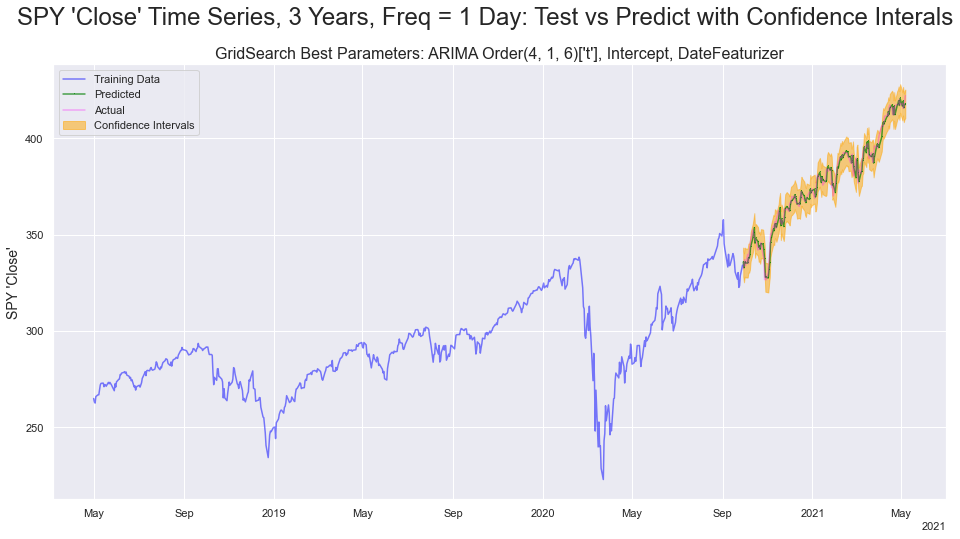

In [131]:
pam_3Y_best, scores = pam_3Y_close.run_gridsearch_CV(min_order=6, max_order=10, t_list=['t','ct'], with_intercept=True, f_m=252, # k=2,
                                             fourier=False, box=False, log=False, debug=True, verbose=0, parallel=False)

In [135]:
pam_3Y_best = pam_3Y_best[0]

In [107]:
pam_3Y_close.mod_params_df.iloc[0]

ARIMA_Order    (0, 0, 0)
Trend                  t
Intercept           auto
Date                True
Fourier             True
Fourier_m            252
Fourier_k              4
BoxCox             False
Log                False
Scored             False
AIC                 None
RMSE                None
RMSE%               None
SMAPE               None
Name: 0, dtype: object

#### Volume

In [317]:
pam_3Y_vol = Pmdarima_Model(df_3Y_vol, 'SPY \'Volume\'', train_size=80,
                            n=3, periods='years', freq='1 Day',  order=(1, 1, 1), seas=252, f_seas=252,
                            with_intercept=False, fit_seas=False, k=4,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=True)

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


TypeError: __init__() got an unexpected keyword argument 'no_intercept'

In [ ]:
pam_3Y_vol_AA = pam_3Y_vol.run_auto_pipeline(verbose=2, visualize=True)

In [ ]:
pam_3Y_vol_best, scores = pam_3Y_vol.run_gridsearch_CV(max_order=2,
                                                       t_list=['n','c','t','ct'],
                                                   fourier=True, box=False, log=True,
                                                   verbose=1, debug=True, parallel=False)

In [ ]:
AIC, RMSE, RMSE_pc, SMAPE = pam_3Y_vol.run_stepwise_CV(pam_3Y_vol_best, dynamic=False, verbose=1, visualize=True)

### Cross-Validation

In [37]:
# cv = pam.model_selection.RollingForecastCV()
cv = pm.model_selection.SlidingWindowForecastCV(window_size=100,step=1)

#### Sliding Window

In [41]:
best_arima = pam_3Y_auto_pipe.named_steps['arima'].model_

In [42]:
est = pm.ARIMA(order = best_arima.order, intercept=False)
cv = pm.model_selection.SlidingWindowForecastCV(window_size=200, step=1, h=100)
predictions = pm.model_selection.cross_val_predict(
    est, df_3Y_close, cv=cv, verbose=1, averaging="median")

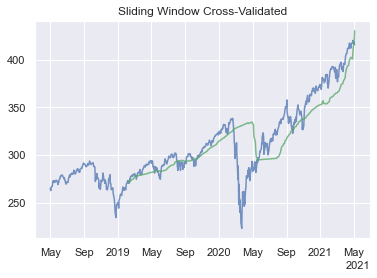

In [43]:
plt.plot(df_3Y_close.index, df_3Y_close.values, alpha=0.75, c='b')
plt.plot(df_3Y_close.index[-predictions.size:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Sliding Window Cross-Validated")
plt.show()

#### Rolling

In [44]:
half_index = round(df_3Y_close.size/2)

In [45]:
est = pm.ARIMA(order = best_arima.order, intercept=False)
# est = pipe
# cannot use pipeline
cv = pm.model_selection.RollingForecastCV(initial=half_index)
# cannot return conf_int, even with return_conf_int=True
predictions = pm.model_selection.cross_val_predict(
    est, df_3Y_close.interpolate(), cv=cv, verbose=1, averaging="median")


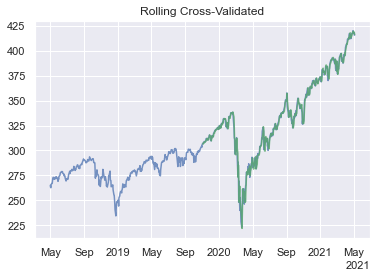

In [46]:
plt.plot(df_3Y_close.index, df_3Y_close.values, alpha=0.75, c='b')
plt.plot(df_3Y_close.index[-predictions.size:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Rolling Cross-Validated")
plt.show()

In [47]:
rmse = mse(df_3Y_close.interpolate()[-predictions.size:], predictions)
rmse

24.796568530528145

### Manual Run

In [50]:
train, test = pm.model_selection.train_test_split(df_3Y_close, train_size=80/100)

X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_3Y.length))
y_test = test.values

In [53]:
train, test = pm.model_selection.train_test_split(df_3Y_vol, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_3Y.length))
y_test = test.values

In [55]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)

In [56]:
pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 start_p=0,
                                 start_q=0,
                                 max_p=0,
                                 min_p=0,
                                 max_q=0,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [57]:
pipe.fit(y_train, X_train)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23420.807, Time=0.11 sec
First viable model found (23420.807)
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26837.723, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.229 seconds


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 AutoARIMA(d=1, max_p=0, max_q=0, seasonal=False, start_p=0,
                           start_q=0, trace=3))])

In [61]:
y_hat = pipe.predict(X=X_test)

Text(0, 0.5, "(SPY 'Volume'")

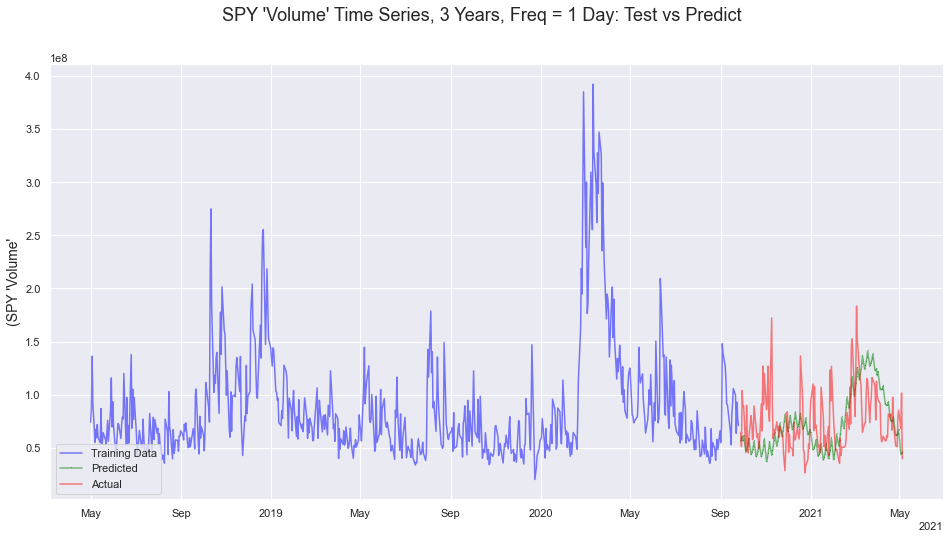

In [68]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
ax.plot(X_test, y_hat, color='green', marker=',', alpha=0.5, label='Predicted')
ax.plot(X_test, y_test, color='red', alpha=0.5, label='Actual')
ax.legend(loc='lower left', borderaxespad=0.5)
fig.suptitle(f'SPY \'Volume\' Time Series, 3 Years, Freq = 1 Day: Test vs Predict\n', size=18)
# ax.set_title(f'Parameters: {params}', size=16)
ax.set_ylabel('(SPY \'Volume\'', size=14)

### Test out Stepwise CV

In [69]:
y_hat, conf_ints = pipe.predict(X=X_test, return_conf_int=True)

In [72]:
date = X_test.iloc[0].date + CBD
conf_int = np.asarray(conf_ints)

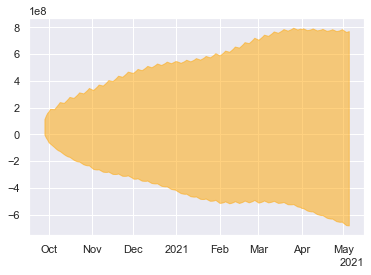

In [73]:
fig, ax = plt.subplots()
ax.fill_between(X_test.date,
               conf_int[:, 0], conf_int[:, 1],
               alpha=0.5, color='orange',
               label="Confidence Intervals")

Text(0, 0.5, "SPY 'Volume'")

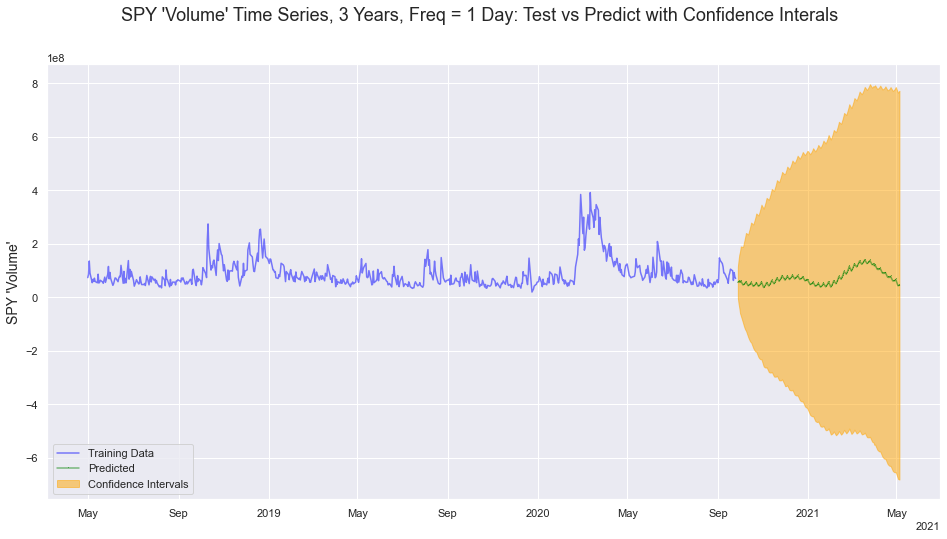

In [76]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
ax.plot(X_test, y_hat, color='green', marker=',', alpha=0.5, label='Predicted')
conf_int = np.asarray(conf_ints)
ax.fill_between(X_test.date,
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.5, color='orange',
         label="Confidence Intervals")
ax.legend(loc='lower left', borderaxespad=0.5)
fig.suptitle(f'SPY \'Volume\' Time Series, 3 Years, Freq = 1 Day: Test vs Predict with Confidence Interals\n', size=18)
ax.set_ylabel('SPY \'Volume\'', size=14)

## Last 5 Years, 1 Day

In [78]:
pam_5Y = Pmdarima_Model(df_5Y_close, 'SPY \'Close\'',
               n=3, periods='years', freq='1 Day', seas=261, f_seas=261, fit_seas=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1,
               date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Data set diffs to use: 1


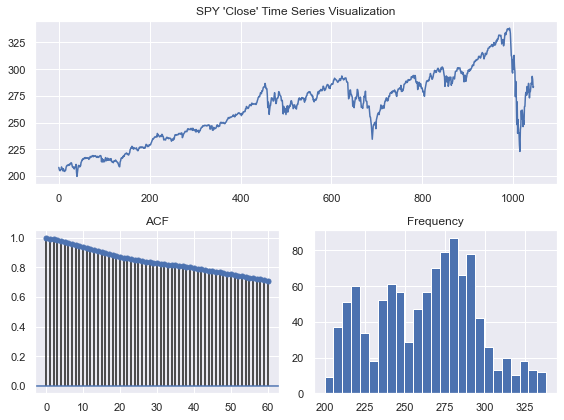

Using DateFeaturizer.
Using FourierFeaturizer.
Parameters for Pipeline: 
[('date', DateFeaturizer(column_name='date')), ('fourier', FourierFeaturizer(k=4, m=261)), ('arima', AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5307.677, Time=3.28 sec
First viable model found (5307.677)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5379.218, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5327.182, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5338.783, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5377.775, Time=1.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5309.119, Time=2.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5315.818, Time=4.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5242.366, Time=3.95 sec
New best model found (5242.366 < 5307.677)
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5261.495, Time=2.98 sec
Near non-invertible roots for order (4, 1, 2)(0, 0, 0,

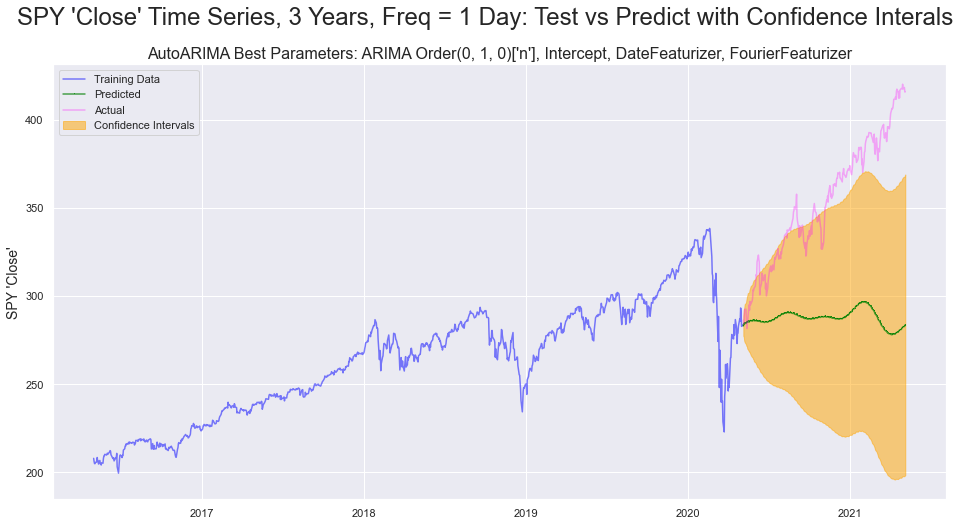

In [81]:
pam_5Y_close = pam_5Y.run_auto_pipeline(show_summary=True, visualize=True)

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
Test AIC: 6688.366
Test RMSE: 3.681
This is 1.399% of the avg observed value.
Test SMAPE: 0.819%



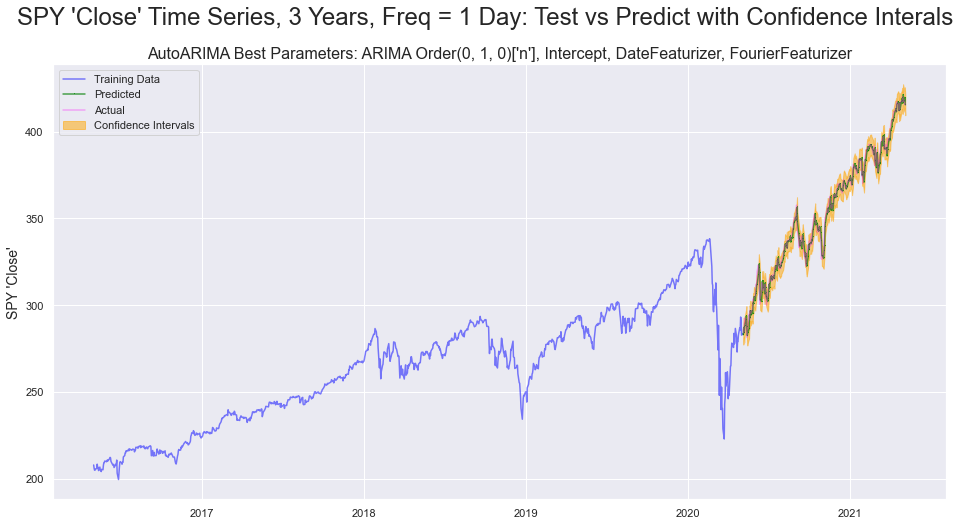

In [82]:
AIC, RMSE, SMAPE = pam_5Y.run_stepwise_CV(dynamic=False, visualize=True)

In [ ]:
pam_5Y_best = pam_5Y.run_gridsearch_CV(debug=True)

## Last 10 Years, 1 Day

In [112]:
pam_10Y_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', f_seas=261, seas=261,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


In [144]:
pam_10_pipe.named_steps['fourier'].m

261

Starting AutoARIMA...
Data set diffs to use: 1
Parameters for Pipeline: 
AutoARIMA, Intercept, DateFeaturizer, FourierFeaturizer

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8004.127, Time=20.55 sec
First viable model found (8004.127)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8008.863, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8009.629, Time=1.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8009.579, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8010.938, Time=1.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8003.929, Time=16.26 sec
New best model found (8003.929 < 8004.127)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8010.773, Time=3.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8000.441, Time=9.79 sec
New best model found (8000.441 < 8003.929)
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8002.387, Time=50.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8010.858, Time=1.85 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=

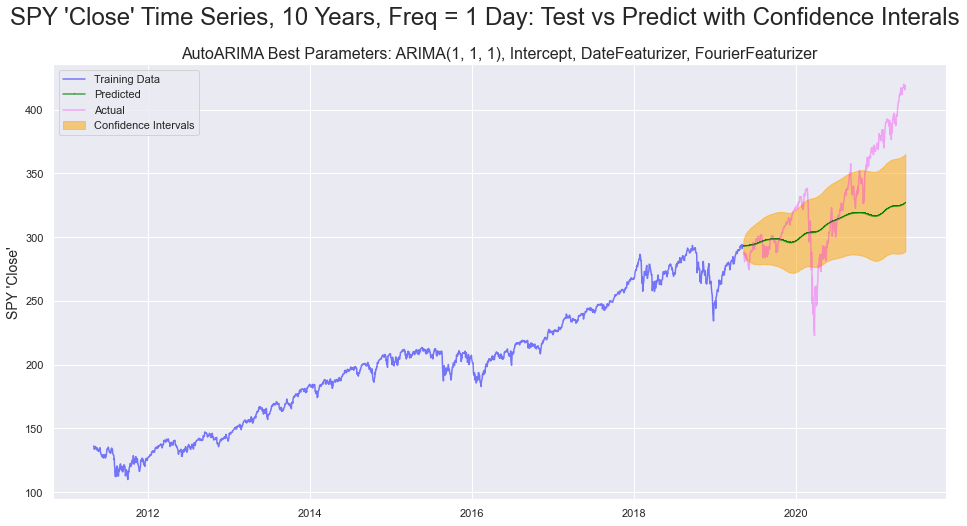

In [116]:
pam_10_pipe = pam_10Y_close.run_auto_pipeline(verbose=1, visualize=True)

### GridSearch

Starting GridSearchCV...
ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 1, 0)['c'], Intercept

_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 12009.023 | RMSE: 4.660 | SMAPE 0.982%
Model[ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12009.023 | RMSE=4.660 | SMAPE=0.982%
First viable model found, RMSE=4.660
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 12006.112 | RMSE: 4.657 | SMAPE 0.978%
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12006.112 | RMSE=4.657 | SMAPE=0.978%
Next best model found, RMSE=4.657
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 12009.829 | RMSE: 4.648 | SMAPE 0.976%
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12009.829 | RMSE=4.648 | SMAPE=0.976%
Next best model found, RMSE=4.648
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 12011.439 | RMSE: 4.655 | SMAPE 0.978%
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12011.439 | RMSE=4.655 | SMAPE=0.978%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11957.270 | RMSE: 4.607 | SMAPE 0.972%
Model[ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11957.270 | RMSE=4.607 | SMAPE=0.972%
Next best model found, RMSE=4.607
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11952.623 | RMSE: 4.602 | SMAPE 0.967%
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11952.623 | RMSE=4.602 | SMAPE=0.967%
Next best model found, RMSE=4.602
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11959.192 | RMSE: 4.604 | SMAPE 0.967%
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11959.192 | RMSE=4.604 | SMAPE=0.967%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11964.814 | RMSE: 4.649 | SMAPE 0.968%
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11964.814 | RMSE=4.649 | SMAPE=0.968%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11921.140 | RMSE: 4.586 | SMAPE 0.967%
Model[ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11921.140 | RMSE=4.586 | SMAPE=0.967%
Next best model found, RMSE=4.586
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11917.914 | RMSE: 4.583 | SMAPE 0.963%
Model[ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11917.914 | RMSE=4.583 | SMAPE=0.963%
Next best model found, RMSE=4.583
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11920.300 | RMSE: 4.569 | SMAPE 0.960%
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11920.300 | RMSE=4.569 | SMAPE=0.960%
Next best model found, RMSE=4.569
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11925.531 | RMSE: 4.623 | SMAPE 0.966%
Model[ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11925.531 | RMSE=4.623 | SMAPE=0.966%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11945.625 | RMSE: 4.596 | SMAPE 0.970%
Model[ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11945.625 | RMSE=4.596 | SMAPE=0.970%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11940.890 | RMSE: 4.590 | SMAPE 0.965%
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11940.890 | RMSE=4.590 | SMAPE=0.965%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11944.217 | RMSE: 4.617 | SMAPE 0.965%
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11944.217 | RMSE=4.617 | SMAPE=0.965%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11946.553 | RMSE: 4.614 | SMAPE 0.964%
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11946.553 | RMSE=4.614 | SMAPE=0.964%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11934.953 | RMSE: 4.677 | SMAPE 0.987%
Model[ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11934.953 | RMSE=4.677 | SMAPE=0.987%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 12005.407 | RMSE: 4.662 | SMAPE 0.986%
Model[ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12005.407 | RMSE=4.662 | SMAPE=0.986%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 12537.598 | RMSE: 4.637 | SMAPE 0.973%
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12537.598 | RMSE=4.637 | SMAPE=0.973%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 13051.724 | RMSE: 4.640 | SMAPE 0.975%
Model[ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=13051.724 | RMSE=4.640 | SMAPE=0.975%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11925.444 | RMSE: 4.591 | SMAPE 0.967%
Model[ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11925.444 | RMSE=4.591 | SMAPE=0.967%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11921.800 | RMSE: 4.587 | SMAPE 0.963%
Model[ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11921.800 | RMSE=4.587 | SMAPE=0.963%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11924.492 | RMSE: 4.606 | SMAPE 0.965%
Model[ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11924.492 | RMSE=4.606 | SMAPE=0.965%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11927.843 | RMSE: 4.589 | SMAPE 0.961%
Model[ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11927.843 | RMSE=4.589 | SMAPE=0.961%

GridsearchCV Completed.

Top 10 models:
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11920.300 | RMSE=4.569 | SMAPE=0.960%
Model[ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11917.914 | RMSE=4.583 | SMAPE=0.963%
Model[ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11921.140 | RMSE=4.586 | SMAPE=0.967%
Model[ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11921.800 | RMSE=4.587 | SMAPE=0.963%
Model[ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11927.843 | RMSE=4.589 | SMAPE=0.961%
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11940.890 | RMSE=4.590 | SMAPE=0.965%
Model[ARIMA Order(2, 1, 0)['n'], Intercept, DateFe

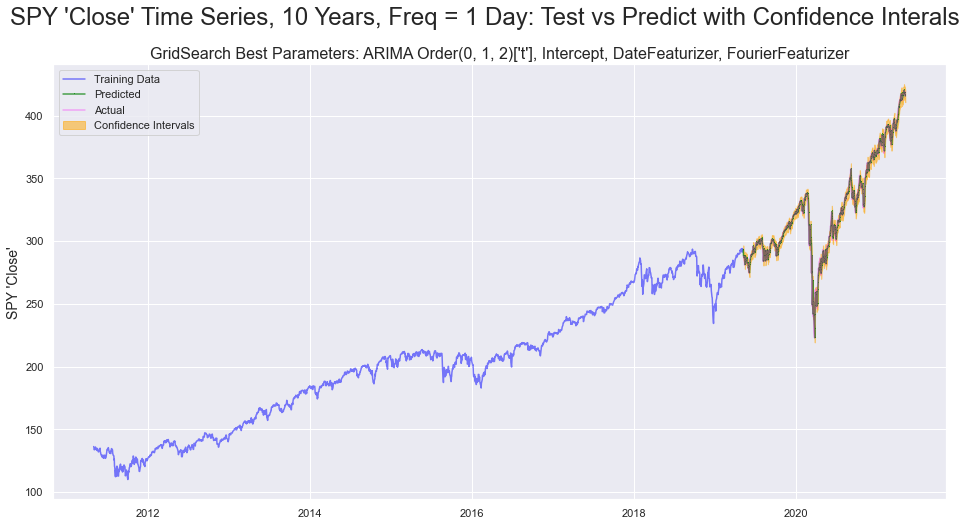

In [121]:
# Using an abbreviated set of params
pam_10Y_best, scores = pam_10Y_close.run_gridsearch_CV(max_order=2, max_d=2,
#                                                  t_list=['t'],
                                                 fourier=True, box=False, log=False,
                                                 verbose=1, debug=True, parallel=False)

In [122]:
Audio(sound_file, autoplay=True)

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
Pmdarima_Model.py loaded from {top}/data..


Pmdarima_Model.py loaded.
ARIMA(1, 1, 1), Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4,
                           with_intercept=True))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_

> 
Done.
Test AIC: 12005.407
Test RMSE: 4.662
This is 2.322% of the avg observed value.
Test SMAPE: 0.986%



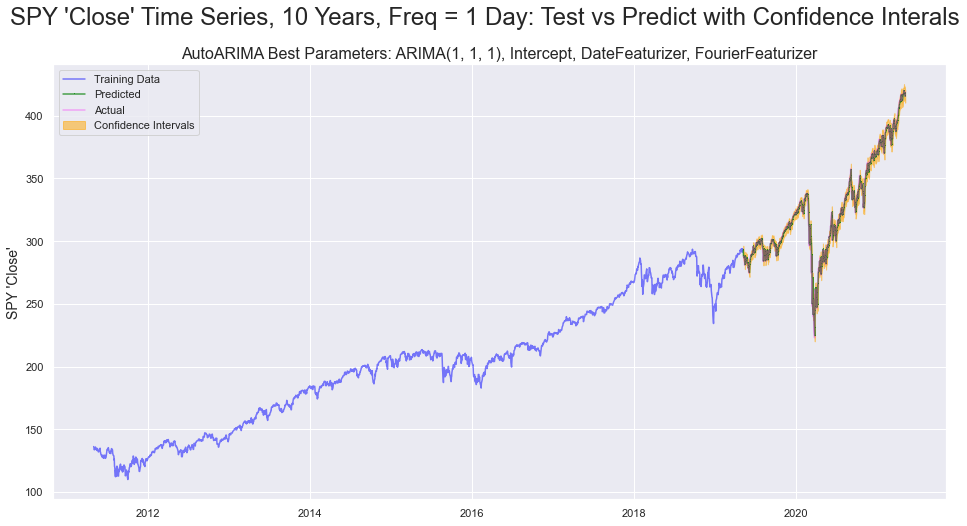

In [120]:
AIC, RMSE, SMAPE = pam_10Y_close.run_stepwise_CV(pam_10Y_best, func='GS', dynamic=False, verbose=1, visualize=True)

Pmdarima_Model.py loaded.


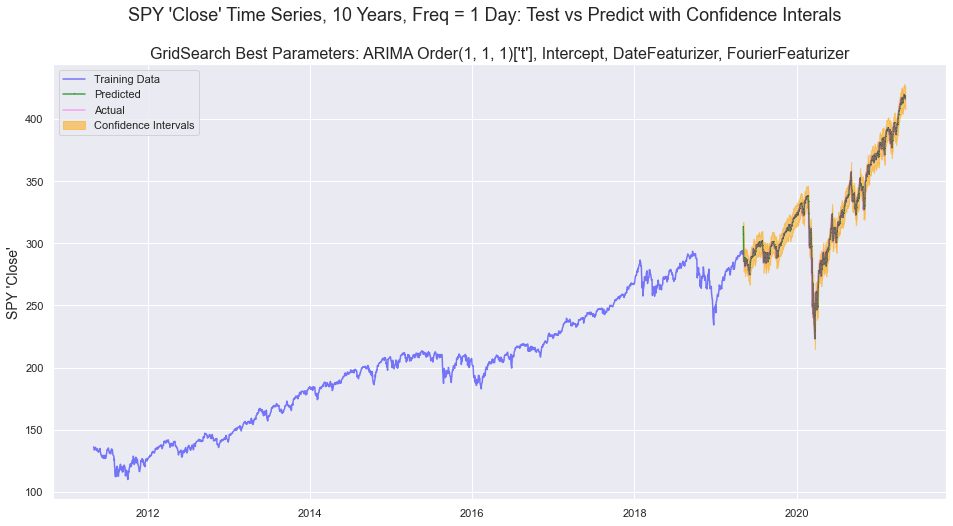

In [152]:
pam_10Y_close.plot_test_predict(pam_10Y_close.y_hat, func='GS', conf_ints=pam_10Y_close.conf_ints)

In [ ]:
AIC, RMSE, SMAPE = pam_10Y_close.run_stepwise_CV(pam_10Y_close.GS_best_mod_pipe, dynamic=False, verbose=1, visualize=True)

#### Manual Run

In [ ]:
dates_10Y = pd.DataFrame(df_10Y_close.index, columns=['date'])
dates_10Y

In [57]:
date_df = new_dates_10Y_df[0:1]
date_df

,date
2613,2021-05-06 14:34:29.418608


##### Close Only

In [49]:
pam_10Y_close = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=4, m=261)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])

In [50]:
pam_10Y_close.fit(df_10Y_close, dates_10Y)

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])

In [58]:
# close_hat, close_conf_ints = pam_10Y_close.predict(X=new_dates_df, return_conf_int=True)
close_hat, close_conf_ints = pam_10Y_close.predict(X=date_df, return_conf_int=True)
close_hat

array([416.04524828])

In [523]:
close_conf_ints

array([[409.31738871, 418.92767348]])

In [59]:
pam_10Y_close = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=4, m=261)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
pam_10Y_close.fit(df_10Y_close, dates_10Y)
close_hat, close_conf_ints = pam_10Y_close.predict(X=date_df, return_conf_int=True)
close_hat

array([415.9116414])

##### Volume

In [ ]:
pam_10Y_vol.fit(df_10Y_vol, dates_10Y)

In [ ]:
vol_hat, vol_conf_ints = pam_10Y_vol.predict(X=new_dates_df, return_conf_int=True)
vol_hat

In [ ]:
vol_hat_df = pd.DataFrame(vol_hat, index=index_fc, columns=['volume'])
vol_hat_df = vol_hat_df.join(new_dates_df)
vol_hat_df

In [96]:
train, test = pm.model_selection.train_test_split(df_10Y_close, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_10Y_close.length))
y_test = test.values

X_test

,date
2090,2019-05-06
2091,2019-05-07
2092,2019-05-08
2093,2019-05-09
2094,2019-05-10
...,...
2608,2021-04-29
2609,2021-04-30
2610,2021-05-03
2611,2021-05-04


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
Test AIC: 730.867
Test RMSE: 31034500.027
This is 25.950% of the avg observed value.
Test SMAPE: 22.808%



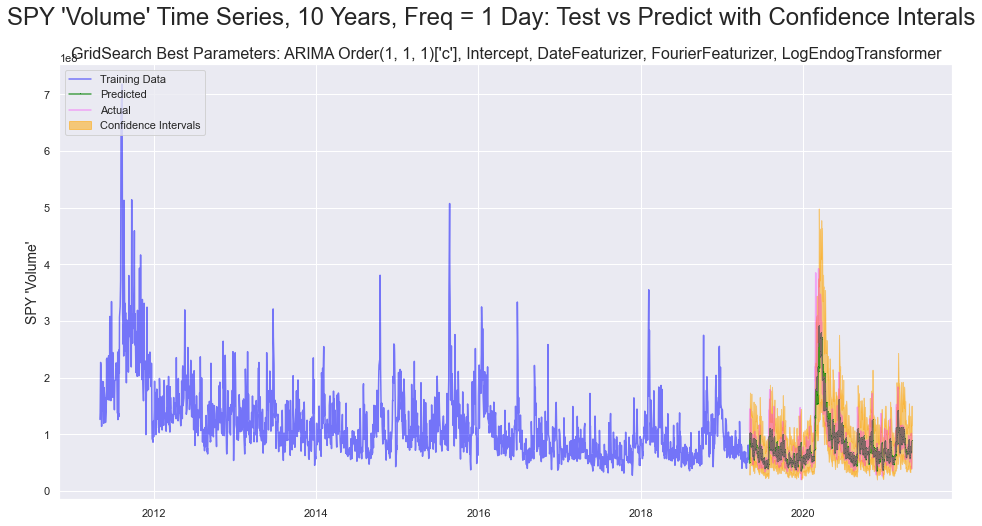

In [31]:
AIC, RMSE, SMAPE = pam_10Y_vol.run_stepwise_CV(pam_10Y_vol_best, func='GS', dynamic=False, verbose=1, visualize=True)

In [33]:
pam_10Y_vol.y_hat

[49278028.8340929,
 82449731.30611807,
 101984583.51983163,
 80500324.25265357,
 92292008.34662569,
 78444889.21737492,
 100886386.30734552,
 80000935.58004633,
 76836001.5210743,
 82881419.30917634,
 76838319.05785337,
 70798961.88253729,
 60972670.820110105,
 60569060.58712146,
 92562203.48496078,
 54404790.1944264,
 67845140.0538666,
 73363562.7290432,
 90305556.69966596,
 72910096.03651996,
 72030314.06895778,
 88654665.88851836,
 81031001.12236844,
 76108807.98490693,
 79104752.01485673,
 65397294.18135849,
 68664931.36522743,
 68237528.9421217,
 58790742.089202955,
 62337002.7220155,
 50956061.28060004,
 50412105.49324121,
 77532351.71062009,
 73625690.61985487,
 97322340.84881155,
 66063103.48767689,
 57342196.63155666,
 77722317.71181978,
 59560014.24131452,
 54185186.77820849,
 54304261.638268776,
 72921728.02036957,
 65259186.134099156,
 51001442.313262865,
 56468662.6432633,
 47271553.34218468,
 51583688.404506505,
 48846367.50482711,
 57472925.041389994,
 56189179.28738522,

Pmdarima_Model.py loaded.


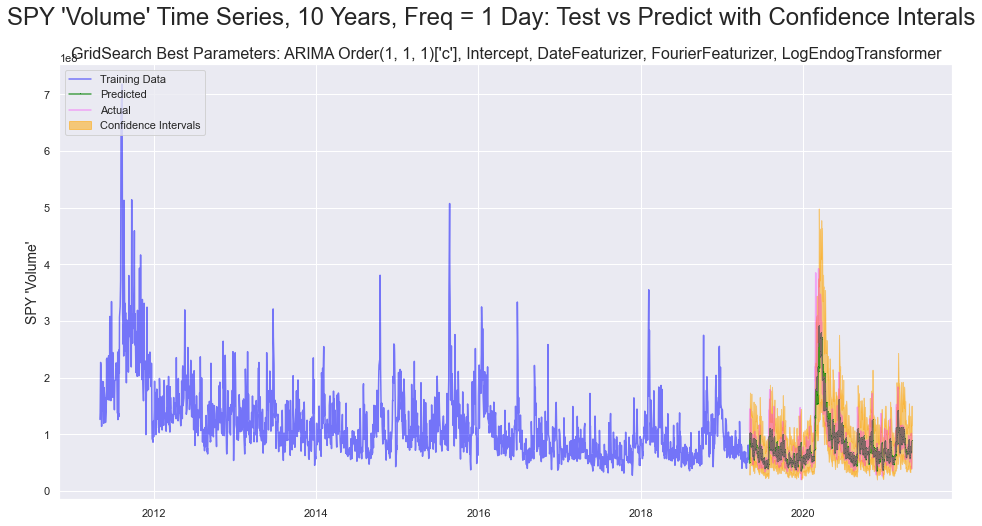

In [34]:
pam_10Y_vol.plot_test_predict(y_hat=pam_10Y_vol.y_hat, conf_ints=True, func='GS')
# AIC, RMSE, SMAPE = pam_10Y_vol.plot_test_predict(conf_ints=pam_10Y_vol.conf_ints, func='GS')

### Manual Forecast

In [ ]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
# _, X_train_feats = date_feat.fit_transform(y_train, X_train)
_, X_train_feats = date_feat.fit_transform(df_10Y_close, dates_10Y)
full_10Y_pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [ ]:
vol_10Y_df = pd.DataFrame(df_10Y_vol).reset_index()

In [ ]:
full_10Y_pipe.fit(df_10Y_close, vol_10Y_df)

In [ ]:
close_vol_hat, close_vol_conf_ints = full_10Y_pipe.predict(X=vol_hat_df, return_conf_int=True)
close_vol_hat

In [203]:
close_vol_hat = np.asarray([414.79630855, 414.60707979, 414.48872733, 414.77080045,
       414.65227317])

#### Plot

In [ ]:
new_fc_df = pd.DataFrame(zip(new_dates_df.date.values,close_vol_hat), columns=['date','close'])
new_fc_df.set_index('date', inplace=True)

In [ ]:
spy_df_10Y_fc = spy_df_10Y.append(new_fc_df)

In [ ]:
new_fc_df = pd.DataFrame(zip(new_dates_df.date.values,close_vol_hat), columns=['date','close'])
new_fc_df.set_index('date', inplace=True)
spy_df_10Y_fc = spy_df_10Y.append(new_fc_df)

In [ ]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(24, 16))
mpl.plot(spy_df_10Y[-120:],
         type='candle',
         style="yahoo",
         ax=ax,
         )
ax.plot(range(120,125), close_vol_hat, 'g.', markersize=10, alpha=0.7, label='Forecast')
# conf_int = np.asarray(close_vol_conf_ints)
conf_int = close_vol_conf_ints
ax.fill_between(range(120,125),
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.3, color='orange',
         label="Confidence Intervals")
ax.set_xlim(0, 130)
ax.set_ylabel('Closing Price (USD)', size=16)
ax.set_title('Using ARIMA(3,1,2), FourierFeaturizer', size=18)
equidate_ax(fig, ax, spy_df_10Y_fc[-125:].index.date)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
fig.subplots_adjust(top=0.92)
ax.legend(loc='upper left', borderaxespad=0.5, fontsize = 18)
fig.suptitle(f'{ylabel} Time Series, 10 Years, Freq = 1 Day: Historical vs Forecast with Confidence Interals\n', size=24)

### Stepwise CV

In [437]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
full_10Y_pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [454]:
# full_10Y_pipe.fit(df_10Y_close.values, pd.DataFrame(df_10Y_close.index))
# full_10Y_pipe.fit(df_10Y_close.values, dates_10Y)
full_10Y_pipe.fit(y_test, X_test)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3051.921, Time=1.07 sec
First viable model found (3051.921)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3090.663, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3059.319, Time=1.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3067.151, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3090.010, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3050.890, Time=0.85 sec
New best model found (3050.890 < 3051.921)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3049.213, Time=0.79 sec
New best model found (3049.213 < 3050.890)
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3050.648, Time=1.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3057.010, Time=0.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3050.165, Time=2.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3048.629, Time=0.78 sec
New best model found (3048.629 < 3049.213)
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3067.371, Time=0.66 sec


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima', AutoARIMA(d=1, seasonal=False, trace=3))])

In [467]:
# RMSE = mse(df_10Y_close, y_hat, squared=False)
RMSE = mse(test, y_hat, squared=False)
print("Test RMSE: %.2f" % RMSE)
print("This is %.2f%% of the avg observed value." % (100*RMSE/y_train.mean()))
print("Test SMAPE: %.2f%%\n" % smape(test, y_hat))
# print("Test SMAPE: %.2f%%\n" % smape(df_10Y_close, y_hat))

Test RMSE: 10.95
This is 5.46% of the avg observed value.
Test SMAPE: 1.07%



In [468]:
fc, conf_ints = model.predict(X=new_dates_df, return_conf_int=True)

In [469]:
fc

array([416.95933521, 413.52184596, 409.9202409 , 406.34035504,
       406.80537236])

In [470]:
conf_ints

array([[392.61884771, 441.2998227 ],
       [379.31263146, 447.73106046],
       [367.90927322, 451.93120859],
       [357.76492447, 454.9157856 ],
       [352.4526033 , 461.15814141]])

### Programmatically Forecasting

In [129]:
# defining a specific model
train, test = pm.model_selection.train_test_split(df_10Y_vol, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
X_test = pd.DataFrame(test.index, index=range(X_train.size, df_10Y_vol.size))
y_test = test.values
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
pam_10Y_vol_new = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=100, m=261)),
                ('log', pm.preprocessing.LogEndogTransformer()),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(1, 1, 2), suppress_warnings=True,
#                        trend='c'
                         ))])

In [131]:
pam_10Y_vol_new.named_steps['arima'].trend

In [208]:
mod_params = 'ARIMA(1, 1, 2), Check Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer'
AA_best_params = mod_params
trend = None
with_intercept = True
# mod_params.replace('Check ', '')
AA_best_params

'ARIMA(1, 1, 2), Check Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer'

In [209]:
mod_params.rfind(')')

13

In [116]:
pam_10Y_vol_new.fit(y_train, X_train)

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=100, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 2), suppress_warnings=True,
                       trend='c'))])

In [108]:
trend='c'

In [210]:
if with_intercept:
    AA_best_params = mod_params.replace('Check ', '')
    with_intercept = True
    if trend:
        AA_best_params = mod_params.replace(mod_params[mod_params.rfind(')')], f')[\'{trend}\']')
        t = trend
    else:
        AA_best_params = mod_params.replace(mod_params[mod_params.rfind(')')], ')[\'c\']')
        t = 'c'
else:
    AA_best_params = mod_params.replace('Check Intercept', '')
    with_intercept = False

In [211]:
AA_best_params, t

("ARIMA(1, 1, 2)['c'], Check Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer",
 'c')

In [176]:
mod_params.replace(mod_params[mod_params.rfind(')')], f')[\'{trend}\']')

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
Pmdarima_Model.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data..


"ARIMA(1, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer"

In [177]:
mod_params.replace(mod_params[mod_params.rfind(')')], ')[\'c\']')

"ARIMA(1, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer"

In [96]:
pam_10Y_vol = Pmdarima_Model(df_10Y_vol, 'SPY \'Volume\'', train_size=80,
                            n=10, periods='years', freq='1 Day', trend='c', f_seas=252, k=20,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=True)

Successfully created instance of Class Pmdarima_Model.


In [120]:
pam_10Y_vol_new.predict(X=X_test)

array([8.87948061e+07, 9.78703420e+07, 8.58354615e+07, 8.26956736e+07,
       6.44082326e+07, 6.81241909e+07, 7.34516184e+07, 7.46254553e+07,
       8.53797743e+07, 7.14766641e+07, 7.04815540e+07, 7.19749662e+07,
       6.95002828e+07, 6.30854994e+07, 5.17394268e+07, 6.18283617e+07,
       6.14590961e+07, 5.55783701e+07, 4.86767468e+07, 5.56250333e+07,
       5.57047373e+07, 5.76019209e+07, 5.90544620e+07, 4.87960818e+07,
       6.11711107e+07, 6.38584646e+07, 6.20095298e+07, 6.57594717e+07,
       4.87711782e+07, 5.30820182e+07, 5.56355577e+07, 5.25604681e+07,
       6.19807667e+07, 5.10889157e+07, 4.55403713e+07, 4.52901442e+07,
       5.28994655e+07, 6.08574234e+07, 4.60183592e+07, 4.95706247e+07,
       5.59847895e+07, 5.63534716e+07, 4.53628268e+07, 4.99952136e+07,
       5.29337181e+07, 5.23568391e+07, 5.11129373e+07, 4.27421608e+07,
       4.80748931e+07, 4.54034393e+07, 4.40818497e+07, 4.74164374e+07,
       3.95686738e+07, 4.99722428e+07, 5.58427049e+07, 5.24361237e+07,
      

Starting AutoARIMA...
Data set diffs to use: 1
Parameters for AutoARIMA Pipeline: 
 AutoARIMA, Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=20, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4,
                           with_intercept=True))])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=546.544, Time=70.06 sec
First viable model found (546.544)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1117.520, Time=2.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=821.009, Time=10.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=639.431, Time=39.72 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1115.520, Time=9.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=539.309, Time=72.01 sec
New best model found (539.309 < 546.544)
 ARIM

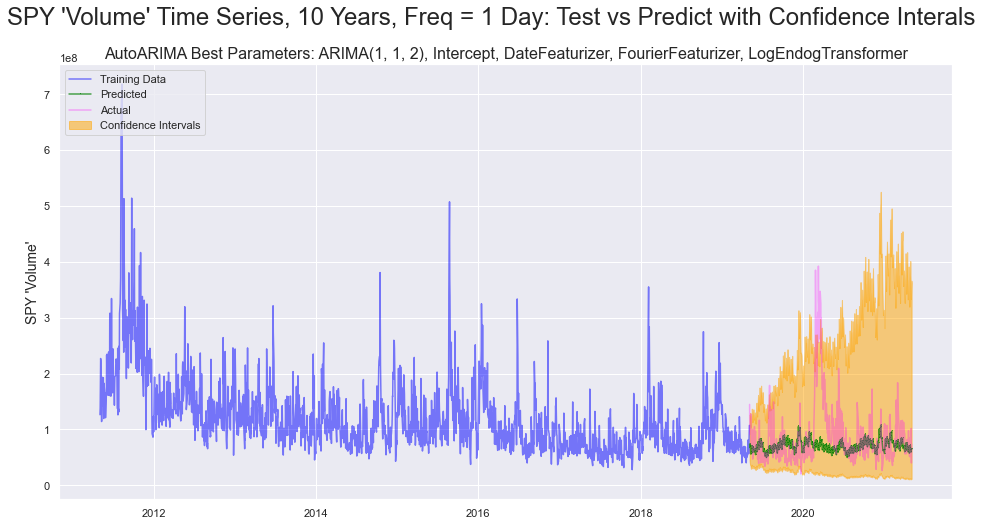

In [97]:
pam_10Y_vol_AA = pam_10Y_vol.run_auto_pipeline(visualize=1, return_conf_int=True, verbose=1)

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
ARIMA(1, 1, 2), Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=20, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4,
                           with_intercept=True))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
Test AIC: 808.927
Test RMSE: 32755708.707
This is 27.280% of the avg observed value.
Test SMAPE: 24.655%



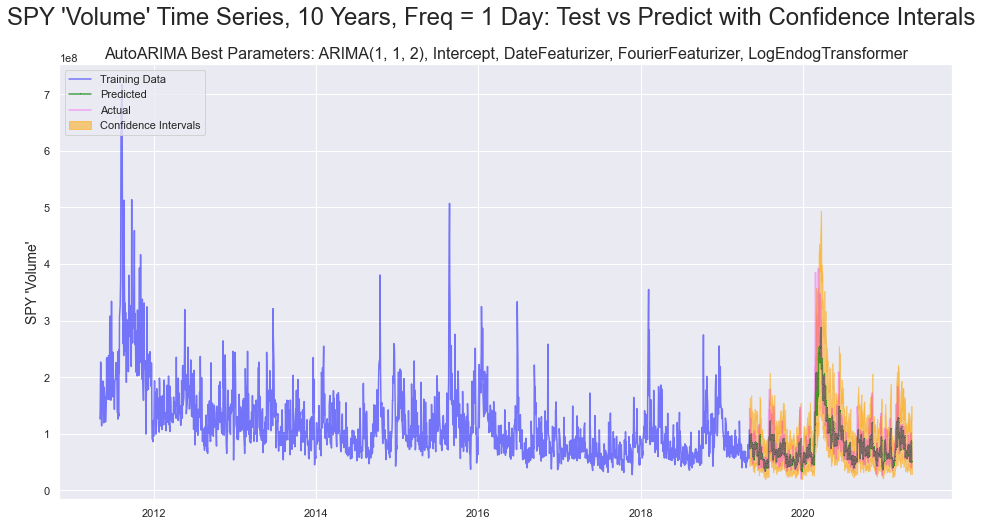

In [98]:
AIC, RMSE, SMAPE = pam_10Y_vol.run_stepwise_CV(dynamic=False, verbose=1, visualize=True)

In [128]:
pam_10Y_vol_new.named_steps['arima'].trend

'c'

In [99]:
Audio(sound_file, autoplay=True)

In [105]:
pam_10Y_vol_AA.named_steps['arima'].model_.trend

In [132]:
pam_10Y_vol = Pmdarima_Model(df_10Y_vol, 'SPY \'Volume\'', train_size=80, with_intercept=False,
                            n=10, periods='years', freq='1 Day', trend='c', f_seas=252, k=9,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=True)

Pmdarima_Model.py loaded from {top}/data..
Successfully created instance of Class Pmdarima_Model.


Pmdarima_Model.py loaded from {top}/data..
Starting AutoARIMA...
Data set diffs to use: 1
Parameters for AutoARIMA Pipeline: 
  AutoARIMA, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=9, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4,
                           with_intercept=False))])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=525.199, Time=43.78 sec
First viable model found (525.199)
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1079.285, Time=4.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=791.227, Time=5.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=633.848, Time=22.00 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=523.219, Time=42.49 sec
New best model found (523.219 < 525.199)
 ARIMA(0,1,2)(0,0,0)[0]             : A

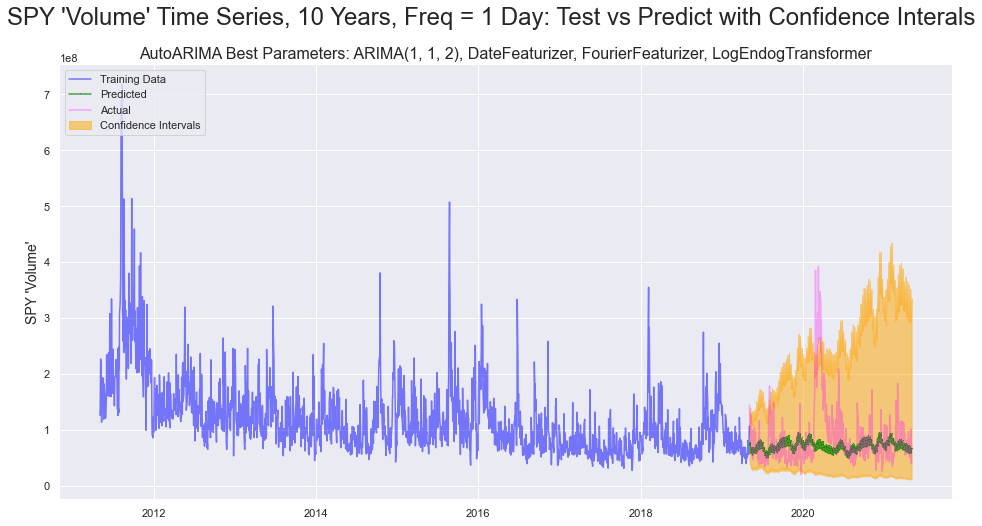

In [134]:
pam_10Y_vol_AA = pam_10Y_vol.run_auto_pipeline(visualize=1, return_conf_int=True, verbose=1)

ARIMA(1, 1, 2), DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=9, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4,
                           with_intercept=False))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
Test AIC: 798.875
Test RMSE: 32725006.504
This is 27.254% of the avg observed value.
Test SMAPE: 24.540%



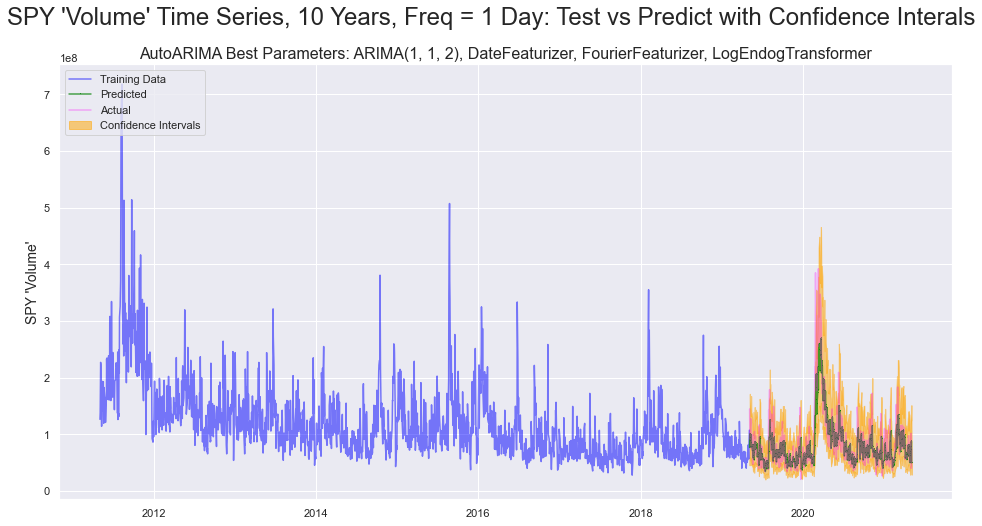

In [143]:
AIC, RMSE, SMAPE = pam_10Y_vol.run_stepwise_CV(dynamic=False, verbose=1, visualize=True)

In [26]:
pam_10Y_vol_best

NameError: name 'pam_10Y_vol_best' is not defined

In [39]:
pam_10Y_vol.AA_mod_pipe.named_steps['arima'].model_.order

(2, 1, 1)

In [ ]:
Audio(sound_file, autoplay=True)

In [136]:
vol_10Y_hat_df, vol_10Y_hat, new_dates_df, vol_10Y_conf_ints = pam_10Y_vol.run_prediction(pam_10Y_vol_best, 12, fin=False,
                            en_ex='exog', hist_df=df_10Y_vol, func='GS', verbose=1)

Successfully created instance of Class Pmdarima_Model.


NameError: name 'pam_10Y_vol_best' is not defined

In [247]:
exog_df = Pmdarima_Model.join_exog_data(new_dates_df, vol_10Y_hat_df)

Successfully created instance of Class Pmdarima_Model.
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 12 days forward.


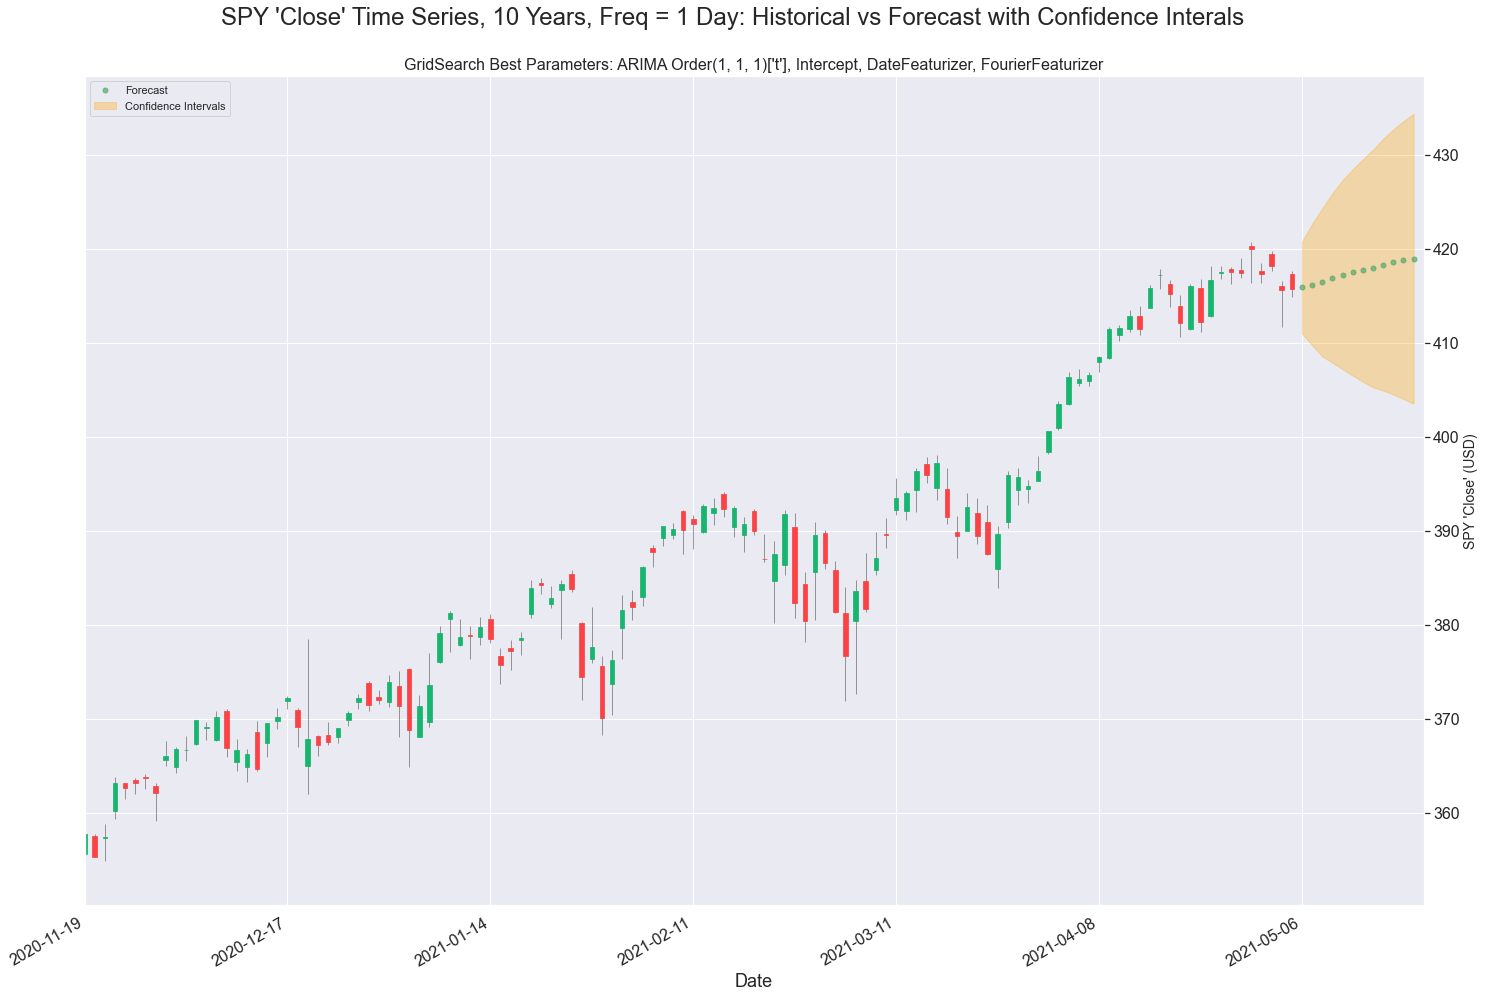

In [248]:
pam_10Y_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80, start_order=(1,1,1),
                            n=10, periods='years', freq='1 Day', f_seas=261, seas=261, trend='t',
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=False)
close_10Y_hat_df, close_10Y_hat, new_dates_df, close_10Y_conf_ints = pam_10Y_close.run_prediction(pam_10Y_best, 12, fin=True,
                            exog_df=exog_df, en_ex='endo', ohlc_df=spy_df_10Y, func='GS', verbose=1)

## Manual testing of pmdarima

In [86]:
# df_train, df_test = train_test_split_data(df_10Y_close, 80, verbose=1)
df_train, df_test = train_test_split_data(df_3Y_close, 80, verbose=1)

##### Train-Test Split #####
Using a 80/20 train-test split...


In [108]:
new_mod = pm.auto_arima(df_train)

In [109]:
new_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  630
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1753.178
Date:                Thu, 06 May 2021   AIC                           3512.355
Time:                        13:47:23   BIC                           3525.688
Sample:                             0   HQIC                          3517.534
                                - 630                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1875      0.018    -10.434      0.000      -0.223      -0.152
ma.L2          0.2166      0.017     12.943      0.000       0.184       0.249
sigma2        15.4317      0.343     45.016      0.000      14.760      16.104
===================================================================================
Ljung-Box (Q):                      101.90   Jarque-Bera (JB):              3424.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.88   Skew:                            -1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
y_hat_test.size

158

In [134]:
start = df_train.size
end = df_3Y_close.size

In [140]:
y_hat_train, conf_int_train = new_mod.predict_in_sample(dynamic=False, return_conf_int=True)
y_hat_test, conf_int_test = new_mod.predict_in_sample(start=start, end=end-1, return_conf_int=True)
# y_hat_train, conf_int_train = new_mod.predict_in_sample(X=df_train.index, dynamic=False, return_conf_int=True)
# y_hat_test, conf_int_test = new_mod.predict_in_sample(X=df_test.index, return_conf_int=True)

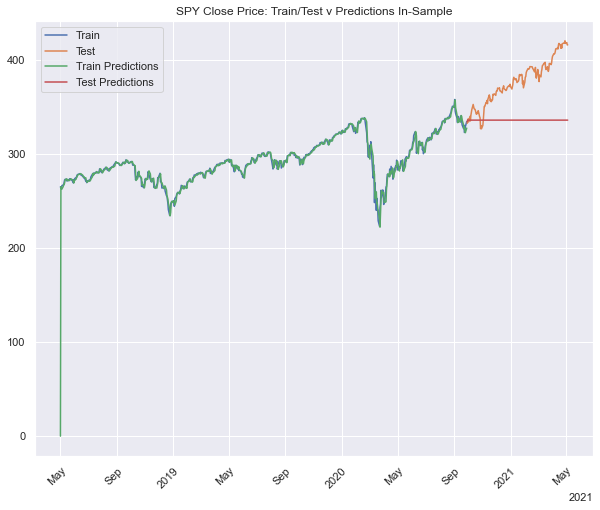

In [141]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(df_train, label='Train')
ax.plot(df_test, label='Test')
ax.plot(df_train.index, y_hat_train, label='Train Predictions')
ax.plot(df_test.index, y_hat_test, label='Test Predictions')
ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
plt.legend()

## All Years, 1 Day

In [136]:
df_all_close

date
1993-01-29     43.937500
1993-02-01     44.250000
1993-02-02     44.343750
1993-02-03     44.812500
1993-02-04     45.000000
                 ...    
2021-05-03    418.200012
2021-05-04    415.619995
2021-05-05    415.750000
2021-05-06    419.070007
2021-05-07    422.119995
Freq: C, Name: close, Length: 7120, dtype: float64

In [154]:
pam_all_close = Pmdarima_Model(df_all_close, 'SPY \'Close\'', train_size=80,
                            n='All', periods='years', freq='1 Day', f_seas=252, seas=252,
                            estimate_diffs=True, impute=False, verbose=1, k=2,
                            date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Data set diffs to use: 1


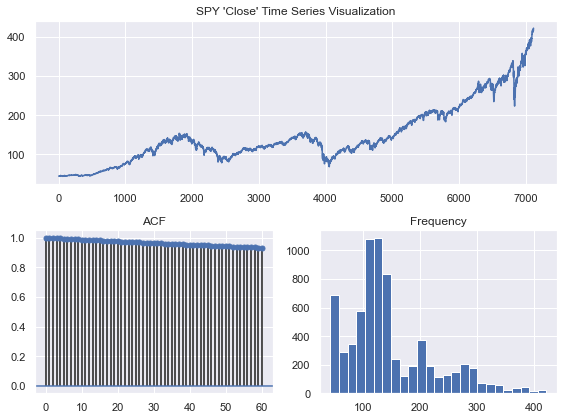

Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19638.228, Time=17.81 sec
First viable model found (19638.228)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19673.523, Time=1.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19661.008, Time=1.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19659.338, Time=3.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19673.768, Time=4.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19636.414, Time=8.33 sec
New best model found (19636.414 < 19638.228)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19645.491, Time=2.80 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19634.942, Time=9.88 sec
New best model 

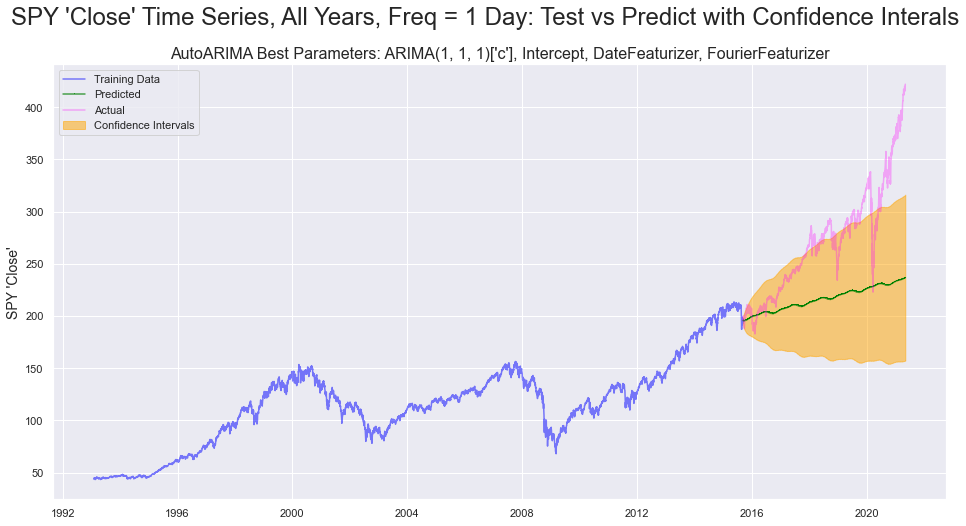

In [155]:
pam_all_close_auto = pam_all_close.run_auto_pipeline(show_summary=True, verbose=1, visualize=True)

ARIMA(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
Test AIC: 29096.870
Test RMSE: 3.210
This is 2.784% of the avg observed value.
Test SMAPE: 0.710%




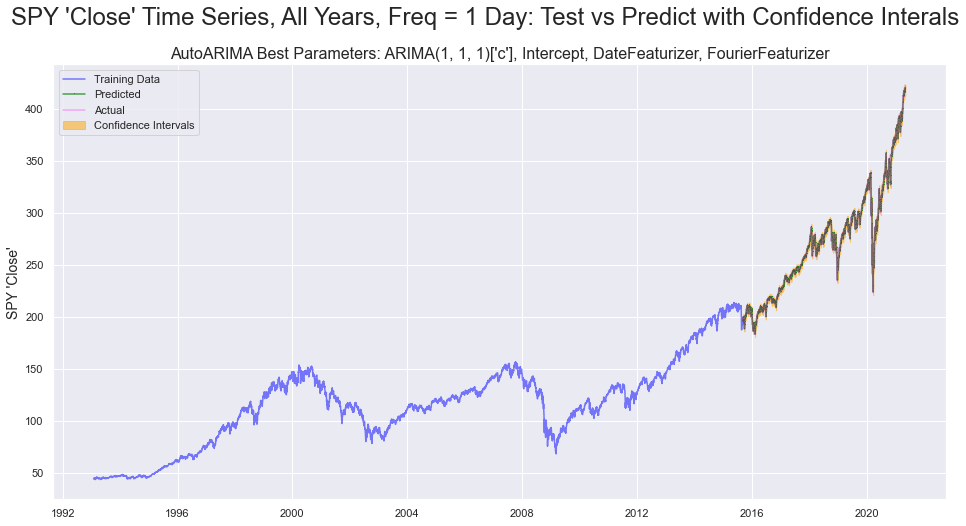

In [156]:
AIC, RMSE, RMSE_pc, SMAPE = pam_all_close.run_stepwise_CV(dynamic=False, verbose=1, visualize=True)

In [163]:
# Using an abbreviated set of params
pam_25Y_best, scores = pam_25Y_close.run_gridsearch_CV(max_order=6, max_d=7,
                                                 t_list=['c','t'], with_intercept=True,
                                                 date=True, fourier=True, box=False, log=False,
                                                 verbose=1, debug=True, parallel=False)

Starting GridSearchCV...
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 3)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 3)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 4)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 4)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 5)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 5)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 1, 0)['t'], Intercept, D

ARIMA Order(1, 3, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 3)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 3)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 4)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 4)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 5)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 5)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 3, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 3, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 3, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 3, 1)['t'], Intercept, DateFeaturizer, FourierFea

ARIMA Order(2, 5, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 3)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 3)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 4)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 4)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(3, 5, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(3, 5, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(3, 5, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(3, 5, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(3, 5, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(3, 5, 2)['t'], Intercept, DateFeaturizer, FourierFea

________________________________________________________________________

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=5, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
>_
Done.
AIC: 26591.364 | RMSE: 3.331 | SMAPE 0.703%
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=26591.364 | RMSE=3.331 | SMAPE=0.703%
First viable model found, RMSE=3.331
________________________________________________________________________

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=5, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 27932.731 | RMSE: 3.330 | SMAPE 0.703%
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=27932.731 | RMSE=3.330 | SMAPE=0.703%
Next best model found, RMSE=3.330
________________________________________________________________________

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=5, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 26497.022 | RMSE: 3.297 | SMAPE 0.698%
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=26497.022 | RMSE=3.297 | SMAPE=0.698%
Next best model found, RMSE=3.297
________________________________________________________________________

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=5, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 27426.357 | RMSE: 3.302 | SMAPE 0.699%
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=27426.357 | RMSE=3.302 | SMAPE=0.699%
________________________________________________________________________

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=5, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 


KeyboardInterrupt: 

# Modeling with all variables

In [ ]:
pam_all_close = Pmdarima_Model(df_all_close, 'SPY \'Close\'', train_size=80,
                            n='All', periods='years', freq='1 Day', seas=261,
                            estimate_diffs=True, impute=False, verbose=0,
                            date=True, fourier=False, box=False, log=False)
pam_all_close_auto = pam_all_close.run_auto_pipeline(show_summary=False, verbose=0, visualize=False)
AA_CV_scores = pam_all_close.run_stepwise_CV(dynamic=False, verbose=0, visualize=True)
pam_all_close_best, scores = pam_all_close.run_gridsearch_CV(min_order=10, max_order=10, max_d=1,
                            t_list=['c', 't', 'ct'], with_intercept=True, m=252, k=2
                            date=True, fourier='auto', box='auto', log=False,
                            verbose=0, debug=False, parallel=False)

In [ ]:
pam_all_open = pam_all_open(df_all_open, 'SPY \'Open\'', train_size=80,
                            n='All', periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0, #k=2,
                            date=True, fourier=False, box=False, log=False)
pam_all_open_auto = pam_all_open.run_auto_pipeline(show_summary=False, verbose=0, visualize=False)
AA_CV_scores = pam_all_open.run_stepwise_CV(dynamic=False, verbose=0, visualize=True)
pam_all_open_best, scores = pam_all_open.run_gridsearch_CV(max_order=1, max_d=1,
                            t_list=['c', 't', 'ct'], with_intercept=True, m=252, k=2
                            date=True, fourier='auto', box='auto', log=False,
                            verbose=0, debug=False, parallel=False)

In [ ]:
pam_all_high = pam_all_high(df_all_high, 'SPY \'High\'', train_size=80,
                            n='All', periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0, #k=2,
                            date=True, fourier=False, box=False, log=False)
pam_all_high_auto = pam_all_high.run_auto_pipeline(show_summary=False, verbose=0, visualize=False)
AA_CV_scores = pam_all_high.run_stepwise_CV(dynamic=False, verbose=0, visualize=True)
pam_all_high_best, scores = pam_all_high.run_gridsearch_CV(max_order=1, max_d=1,
                            t_list=['c', 't', 'ct'], with_intercept=True, m=252, k=2
                            date=True, fourier='auto', box='auto', log=False,
                            verbose=0, debug=False, parallel=False)

In [ ]:
pam_all_low = pam_all_low(df_all_low, 'SPY \'Low\'', train_size=80,
                            n='All', periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0, #k=2,
                            date=True, fourier=False, box=False, log=False)
pam_all_low_auto = pam_all_low.run_auto_pipeline(show_summary=False, verbose=0, visualize=False)
AA_CV_scores = pam_all_low.run_stepwise_CV(dynamic=False, verbose=0, visualize=True)
pam_all_low_best, scores = pam_all_low.run_gridsearch_CV(max_order=1, max_d=1,
                            t_list=['c', 't', 'ct'], with_intercept=True, m=252, k=2
                            date=True, fourier='auto', box='auto', log=False,
                            verbose=0, debug=False, parallel=False)

In [ ]:
pam_all_aclose = pam_all_aclose(df_all_aclose, 'SPY \'Adjusted Close\'', train_size=80,
                            n='All', periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0, #k=2,
                            date=True, fourier=False, box=False, log=False)
pam_all_aclose_auto = pam_all_aclose.run_auto_pipeline(show_summary=False, verbose=0, visualize=False)
AA_CV_scores = pam_all_aclose.run_stepwise_CV(dynamic=False, verbose=0, visualize=True)
pam_all_aclose_best, scores = pam_all_aclose.run_gridsearch_CV(max_order=1, max_d=1,
                            t_list=['c', 't', 'ct'], with_intercept=True, m=252, k=2
                            date=True, fourier='auto', box='auto', log=False,
                            verbose=0, debug=False, parallel=False)

In [ ]:
pam_all_vol = pam_all_vol(df_all_vol, 'SPY \'Volume\'', train_size=80,
                            n='All', periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0, #k=2,
                            date=True, fourier=False, box=False, log=False)
pam_all_vol_auto = pam_all_vol.run_auto_pipeline(show_summary=False, verbose=0, visualize=False)
AA_CV_scores = pam_all_vol.run_stepwise_CV(dynamic=False, verbose=0, visualize=True)
pam_all_vol_best, scores = pam_all_vol.run_gridsearch_CV(max_order=1, max_d=1,
                            t_list=['c', 't', 'ct'], with_intercept=True, m=252, k=2
                            date=True, fourier='auto', box=False, log=True,
                            verbose=0, debug=False, parallel=False)

In [ ]:
open_all_hat_df, open_all_hat, new_dates_df, open_all_conf_ints = pam_all_open.run_prediction(pam_all_open_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=1, visualize=True)

In [ ]:
high_all_hat_df, high_all_hat, new_dates_df, high_all_conf_ints = pam_all_high.run_prediction(pam_all_high_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=1, visualize=True)

In [ ]:
low_all_hat_df, low_all_hat, new_dates_df, low_all_conf_ints = pam_all_low.run_prediction(pam_all_low_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=1, visualize=True)

In [ ]:
aclose_all_hat_df, aclose_all_hat, new_dates_df, aclose_all_conf_ints = pam_all_aclose.run_prediction(pam_all_aclose_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=1, visualize=True)

In [ ]:
vol_all_hat_df, vol_all_hat, new_dates_df, vol_all_conf_ints = pam_all_vol.run_prediction(pam_all_vol_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=1, visualize=True)

In [ ]:
all_exog_df = Pmdarima_Model.join_exog_data(new_dates_df,
                                            open_all_hat_df,
                                            high_all_hat_df,
                                            low_all_hat_df,
                                            aclose_all_hat_df
                                            vol_10Y_hat_df)

In [ ]:
close_all_hat_df, close_all_hat, new_dates_df, close_all_conf_ints = pam_all_close.run_prediction(pam_all_best, 52, fin=True,
                            exog_df=exog_df, en_ex='endo', ohlc_df=spy_df_all, func='GS', verbose=1, visualize=True)